Google Colab

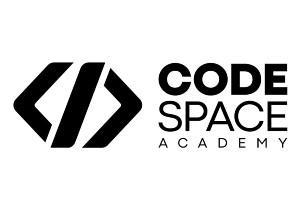

# **0.0** Importaciones y constantes

## Instalaciones

In [1]:
!pip install pymysql
!pip install meteostat
!pip install SQLAlchemy==1.4.48
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 935.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.31
    Uninstalling SQLAlchemy-2.0.31:
      Successfully uninstalled SQLAlchemy-2.0.31
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.48 which is incompatible.


## Importaciones

In [2]:
# este valor DEBE cambiar dependiendo de la ubicación de la carpeta en su entorno de google drive
#   ejemplo: "/content/drive/MyDrive/CodeSpace_DataScience/DataScience/"
localPath= ""
googleColab=True
if googleColab:
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)

notebookCsv_Path="/data/"

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import sqlalchemy as sa
from meteostat import Point, Daily
import datetime
import random

import joblib

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

## Constantes

In [6]:
# Diccionario de modelos para series temporales
models = {
    'model': [
        RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, LinearRegression,
        Ridge, DecisionTreeRegressor, ExtraTreeRegressor, KNeighborsRegressor, SVR
    ],
    'model_name': [
        'RandomForest', 'GradientBoosting', 'AdaBoost', 'LinearRegression',
        'Ridge', 'DecisionTree', 'ExtraTree', 'KNeighbors', 'SVR'
    ]
}

# Diccionario de parámetros específicos y simples para cada modelo
simple_model_params = {
    'RandomForest': {'n_estimators': 100, 'random_state': 42},
    'GradientBoosting': {'n_estimators': 100, 'learning_rate': 0.1},
    'AdaBoost': {'n_estimators': 100, 'learning_rate': 1.0},
    'LinearRegression': {},
    'Ridge': {'alpha': 1.0},
    'Lasso': {'alpha': 1.0},
    'DecisionTree': {'random_state': 42},
    'ExtraTree': {'random_state': 42},
    'KNeighbors': {'n_neighbors': 5},
    'SVR': {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1}
}

# Espacios de hiperparámetros para cada modelo
param_grid = {
    'RandomForest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'LinearRegression': {},
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'ExtraTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1.0, 10.0, 100.0],
        'epsilon': [0.01, 0.1, 1.0]
    }
}


In [7]:
label = ['var1(t)_scld']
weekdays_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
meteovars = ["fecha_venta", "tavg_w", "lluvia", "isfestivo"]

## Funciones

Función para obtener, de un DF dado, todos los items separados por día de la semana en un diccionario

      orderItemsPerDay = supervicedItemsPerDay_Dict(df, n_in_daily=5, n_in_weekly=0)

In [8]:
# Filtrar y reiniciar el índice para cada producto, por cada familia, para cada día
def supervicedItemsPerDay_Dict(df, setDatetime=(2023, 3, 1), n_in_daily=5, n_in_weekly=0, n_out=1, dropnan=True, printAll=True ):
  year, month, day = setDatetime

  orderItemsPerDay = {}
  for family in df["familia"].unique():
      orderItemsPerDay[family] = {}
      for item in df.loc[df["familia"] == family, "articulo"].unique():

          itemDF = df.loc[(df["familia"] == family) & (df["articulo"] == item)].copy()
          if printAll:
            print(f"Para el grupo familiar: {family} con el item: {item}, {itemDF.shape}" )
          itemDF.sort_values(by="fecha_venta", inplace=True)  # Ordenar por fecha
          f = list(itemDF["festivo"].dropna().unique())
          itemDF["isfestivo"] = np.where(itemDF["festivo"].isin(f), 1, 0)
          itemDF["lluvia"] = np.where(itemDF["prcp_w"] > 0, 1, 0)

          itemSales = itemDF.loc[itemDF["fecha_venta"] < datetime.datetime(year, month, day)]
          # itemSalesTest = itemDF.loc[itemDF["fecha_venta"] >= datetime.datetime(2023, 3, 1)]

          itemSales.set_index("fecha_venta", inplace=True)
          if printAll:
            print(f"conjunto de entrenamiento: {itemSales.shape}")
          # itemSalesTest.set_index("fecha_venta", inplace=True)
          # print(f"conjunto de prueba: {itemSales.shape}")

          itemSalesSuperviced = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily=n_in_daily, n_in_weekly=n_in_weekly, n_out=n_out, dropnan=dropnan)
          itemSalesSuperviced.reset_index(inplace=True)

          itemSales.reset_index(inplace=True)  # Se requiere la columna 'fecha_ventas' disponible para hacer el merge
          itemSalesSuperviced = itemSalesSuperviced.merge(itemSales[meteovars], on="fecha_venta", how="inner")

          itemSalesSuperviced['day'] = itemSalesSuperviced['fecha_venta'].dt.day
          itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['fecha_venta'].dt.dayofweek
          itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['dayofweek'] + 1
          itemSalesSuperviced['month'] = itemSalesSuperviced['fecha_venta'].dt.month
          itemSalesSuperviced['year'] = itemSalesSuperviced['fecha_venta'].dt.year
          itemSalesSuperviced['weekday'] = itemSalesSuperviced['dayofweek'] < 6

          itemSalesSuperviced["weekday"] = lb.fit_transform(itemSalesSuperviced["weekday"])

          orderItemsPerDay[family][item] = {}
          for day in range(1, 8):
              itemSalesSuperviced_forDay = itemSalesSuperviced.loc[itemSalesSuperviced["dayofweek"] == day]
              itemSalesSuperviced.reset_index(drop=True, inplace=True)

              orderItemsPerDay[family][item][weekdays_names[day - 1]] = itemSalesSuperviced_forDay
              if printAll:
                print(f"Se completa satisfactoriamente la estrategia de división: {itemSalesSuperviced_forDay.shape} para el día {day} * {weekdays_names[day-1]}")
          if printAll:
            print("\n")
      if printAll:
        print("---------------------------")
        print("\n")
  return orderItemsPerDay

#### Función de escalamiento

In [9]:
def tsscale(df):
  dfScaled = df.copy()
  colstoscaled = df.columns[1:]
  newcols = []
  for i in colstoscaled:
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(np.array(df[i]).reshape(-1,1))
    j = i + "_scld"
    newcols.append(j)
    dfScaled[j] = scaler.transform(np.array(df[i]).reshape(-1,1))
    if i == "var1(t)":
      scalerToUnscale = scaler
  return dfScaled, scalerToUnscale

#### Función para convertr un DataFrame a serie de tiempo supervizada Y = (t)

In [10]:
from pandas import DataFrame, concat

def series_to_supervised(data, n_in_daily=1, n_in_weekly=1, n_out=1, dropnan=True):

  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()

  # input sequence sales for days (t-n, ... , t-1)
  for i in range(n_in_daily, 0, -1):
    cols.append(df.shift(i))
    names += [("var%d(t-%d day)" % (j+1, i)) for j in range(n_vars)]

  # input sequence sales for weeks (t-n, ... , t-1)
  for i in range(n_in_weekly, 0, -1):
    cols.append(df.shift(i*7))
    names += [("var%d(t-%d week)" % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... , t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [("var%d(t)" % (j+1)) for j in range(n_vars)]
    else:
      names += [("var%d(t+%d)" % (j+1)) for j in range(n_vars)]

  # unify
  agg = concat(cols, axis=1)
  agg.columns = names

  #~drop NaN
  if dropnan:
    agg.dropna(inplace=True)

  return agg

#### Función para describir los nulos (valores absolutos y porcentuales) por columna

In [11]:
""" FUNCIÓN PARA DESCRIBIR LOS NULOS (ABSOLUTOS Y PORCENTUALES) POR COLUMNA"""

def checkNullColumns(df, feature_lists=None, info=False):
    total_rows = len(df)
    total_columns = 0
    total_nulls = 0  # Variable para almacenar el total de nulos

    if feature_lists is None:
        # Si no se proporciona una lista de características, analizar el DataFrame completo
        null_counts = df.isnull().sum().sort_values(ascending=False)
        print("Nulls in all columns:")
        for column, null_count in null_counts.items():
            null_percentage = (null_count / total_rows) * 100
            total_nulls += null_count  # Sumar el conteo de nulos
            print(f"{column}: {null_count} ({null_percentage:.1f}%)")
        if info:
          print("\nAnalysis for all numerical columns:")
          print(df.describe())
    else:
        # Si se proporciona una lista de características, analizar cada grupo de columnas
        for features in feature_lists:
            column_counter = 0
            subtotal_rows = len(df[features])
            subtotal_nulls = 0
            null_counts = df[features].isnull().sum().sort_values(ascending=False)
            column_type = "Numerical" if all(pd.api.types.is_numeric_dtype(df[column]) for column in features) else "Categorical"
            print(f"Nulls in {column_type} columns:")
            for column, null_count in null_counts.items():
                null_percentage = (null_count / total_rows) * 100
                total_nulls += null_count  # Sumar el conteo de nulos
                subtotal_nulls += null_count
                print(f"{column}: {null_count} ({null_percentage:.1f}%)")
                column_counter += 1
            average_percentage = (subtotal_nulls / (subtotal_rows * len(features))) * 100
            total_columns += column_counter
            print(f"\t{column_counter} columns, SubTotal nulls: {subtotal_nulls} (average {average_percentage:.1f}%)\n")
            if info:
                print(f"Analysis for this columns:")
                print(df[features].describe(include='all'))
                print("\n")

#### Función para ejecutar todos los modelos de predicción de forma simple, sin hiperparametros, medir sus puntajes y retornar un DF con resultados.

In [12]:
def basic_modelMetrics_compared_ts(data, model_dict, model_params, cv=5, printModel=True):
    x_tr, y_tr, x_te, y_te = data
    results_list = []  # Lista para almacenar los resultados de cada modelo

    best_model = None
    best_model_name = None
    best_model_score = float('inf')  # Inicialmente infinito, para encontrar el mínimo

    for model_class, model_name in zip(model_dict["model"], model_dict["model_name"]):
        params = model_params.get(model_name, {})
        model_instance = model_class(**params)

        # Realizar validación cruzada
        scores = cross_val_score(model_instance, x_tr, y_tr, cv=cv, scoring='neg_mean_absolute_error')
        mean_score = -scores.mean()  # Cross_val_score devuelve la métrica negativa

        model_instance.fit(x_tr, y_tr)
        _pred = model_instance.predict(x_te)

        model_results = {"model": model_name}  # Inicializar un diccionario para cada modelo

        # Calcular métricas en el conjunto de prueba
        mean_ae = mean_absolute_error(y_te, _pred)
        mean_se = mean_squared_error(y_te, _pred)
        median_ae = median_absolute_error(y_te, _pred)

        model_results["CV_Mean_AE"] = round(mean_score, 4)
        model_results["Mean_AE"] = round(mean_ae, 4)
        model_results["Mean_SE"] = round(mean_se, 4)
        model_results["Median_AE"] = round(median_ae, 4)

        results_list.append(model_results)  # Agregar el diccionario a la lista

        # Verificar si este modelo es el mejor hasta ahora en base a la validación cruzada
        if mean_score < best_model_score:
            best_model_score = mean_score
            best_model = model_instance
            best_model_name = model_name

    results_df = pd.DataFrame(results_list).sort_values(by=['CV_Mean_AE'], ascending=True)

    if printModel:
        print(f"Mejor modelo basado en CV: {best_model_name} con CV_Mean_AE: {best_model_score}")

    return results_df, best_model  # Retornar el DataFrame y el mejor modelo ya entrenado
# Ejemplo de cómo llamar a la función con tus datos
# data = (x_tr, y_tr, x_te, y_te)
# results = basic_modelMetrics_compared_ts(data, models, model_params)
# print(results)

#### Función para ejecutar todos los modelos de predicción de forma exahustiva, sin hiperparametros, medir sus puntajes y retornar un DF con resultados.

In [13]:
def hiperparamsSearch_modelMetrics_compared_ts(data, model_dict, param_grid, search_type='random', n_iter=10, printModel=False):
    x_tr, y_tr, x_te, y_te = data
    results_list = []  # Lista para almacenar los resultados de cada modelo

    for model_class, model_name in zip(model_dict["model"], model_dict["model_name"]):
        if printModel:
          print(model_name)
        params = param_grid.get(model_name, {})
        model_instance = model_class()

        if search_type == 'random':
            search = RandomizedSearchCV(model_instance, params, n_iter=n_iter, cv=5, scoring='neg_mean_absolute_error')
        else:  # Exahustive search
            search = GridSearchCV(model_instance, params, cv=5, scoring='neg_mean_absolute_error')

        search.fit(x_tr, y_tr)
        best_model = search.best_estimator_
        _pred = best_model.predict(x_te)

        model_results = {"model": model_name}  # Inicializar un diccionario para cada modelo
        model_results["Best_Params"] = search.best_params_
        model_results["Mean_AE"] = round(mean_absolute_error(y_te, _pred), 4)
        model_results["Mean_SE"] = round(mean_squared_error(y_te, _pred), 4)
        model_results["Median_AE"] = round(median_absolute_error(y_te, _pred), 4)

        results_list.append(model_results)  # Agregar el diccionario a la lista

    return pd.DataFrame(results_list).sort_values(by=['Mean_AE'], ascending=True)  # Convertir la lista de resultados en un DataFrame

#### Función para plotear resultados de predicciones comparadas con datos reales

* **singleResultsAndPlots** es la función que engloba los diferentes *plottings*

In [14]:
def plottingResults(comparison):
  fig, ax = plt.subplots(figsize=(10,8))
  comparison["diff"].hist(bins=10, ax=ax)
  ax.set_xticklabels(ax.get_xticks(), fontsize=8)
  ax.set_yticklabels(ax.get_yticks(), fontsize=8)
  ax.set_xlabel("Error", fontname="Serif", fontsize=8)
  ax.set_title("Histograma del error de predicción", fontname="Serif", fontsize=8)

def plottingSeries(comparison, check=True):
  if check:
    comparison.rename({"Y_real":"venta real", "Y_pred":"venta predicha ML"}, axis=1, inplace=True)
    fig = px.line(comparison, x="fecha", y=["venta real","venta predicha ML"])
    fig.show()
  else:
    comparison.rename({"cantidad":"venta predicha tienda", "Y_real":"venta real", "Y_pred":"venta predicha ML"}, axis=1, inplace=True)
    fig = px.line(comparison, x="fecha", y=["venta real","venta predicha ML", "venta predicha tienda"])
    fig.show()

def plottingComparisson(comparison):
  i=0
  comparison["line"] = [i+j*250/len(comparison) for j in range(len(comparison))]
  comparison["line2"] = comparison["line"]

  fig, ax = plt.subplots(figsize=(10,8))
  comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
  comparison.plot.scatter(x="Y_real", y="Y_pred", ax=ax, color="blue")
  ax.grid("True")
  ax.set_xticklabels(ax.get_xticks(minor=False), fontname="Serif", fontsize=8)
  ax.set_yticklabels(ax.get_yticks(minor=False), fontname="Serif", fontsize=8)
  ax.set_ylabel("Ventas predichas", fontname="Serif", fontsize=8)
  ax.set_xlabel("Ventas reales", fontname="Serif", fontsize=8)
  ax.set_title("ventas reales vs predicciones", fontname="Serif", fontsize=8)
  ax.get_legend().remove()

def singleResultsAndPlots(model, data, plotAll=True, noPlot=False):
  (X_train, Y_train, X_test, Y_test) = data
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)

  # desescalado
  Y_predUnsc = dfTest_unscaler.inverse_transform(Y_pred.reshape(1,-1))[0]
  Y_testUnsc = dfTest_unscaler.inverse_transform(Y_test.reshape(1,-1))[0]

  # validación
  Y_predUnsc = Y_predUnsc.flatten().astype(int)
  Y_testUnsc = Y_testUnsc.flatten()

  # merge
  comparison = pd.DataFrame({"Y_real": Y_testUnsc, "Y_pred": Y_predUnsc})
  comparison["fecha"] = testDates
  comparison["diff"] = abs(comparison["Y_real"] - comparison["Y_pred"])

  if not noPlot:
    print(f"para el modelo {model}")
    # Ploteados y métricas
    print("Metricas de predicción - real")
    print("--M Squared E")
    print(mean_squared_error(comparison["Y_real"].to_list(), comparison["Y_pred"].to_list()))

    print("--M Absolute E")
    print(mean_absolute_error(comparison["Y_real"].to_list(), comparison["Y_pred"].to_list()))

    print("-Error acumulado")
    print(sum(abs(np.array(comparison["Y_real"].to_list()) - np.array(comparison["Y_pred"].to_list()))))

  if plotAll:
    plottingResults(comparison)
    plottingComparisson(comparison)
    plottingSeries(comparison)
  else:
    if not noPlot:
      plottingSeries(comparison)

  return comparison

# **1.0** carga de archivos

## **1.1** Carga de archivos desde la carpeta /datathon_csv

* datos obtenidos del Modulo 2 de Data Analytics: *link a la carpeta de materiales*

In [15]:
originalDataNeeded = False
showDataFrame = ""

In [16]:
if originalDataNeeded:
  articulosPanaderia_df = pd.read_csv(localPath+notebookCsv_Path+"ArticulosPanaderia.csv", delimiter=':')
  print(articulosPanaderia_df.shape)
  # (940425, 8)
  showDataFrame = articulosPanaderia_df.head(3)
showDataFrame

''

In [17]:
if originalDataNeeded:
  cantidadPedida_df = pd.read_csv(localPath+notebookCsv_Path+"CantidadPedida.csv", delimiter=';')
  print(cantidadPedida_df.shape)
  # (107905, 7)
  showDataFrame = cantidadPedida_df.head(3)
showDataFrame

''

In [18]:
if originalDataNeeded:
  calendarioFestivo_df = pd.read_csv(localPath+notebookCsv_Path+"CalendarioFestivo.csv", delimiter=';')
  print(calendarioFestivo_df.shape)
  # (218, 2)
  showDataFrame = calendarioFestivo_df.head(3)
showDataFrame

''

In [19]:
if originalDataNeeded:
  calendarioCompleto_df = pd.read_csv(localPath+notebookCsv_Path+"CalendarioCompleto.csv", delimiter=';')
  print(calendarioCompleto_df.shape)
  # (2556, 3)
  showDataFrame = calendarioCompleto_df.head(3)
showDataFrame

''

## **1.2** carga de archivo: **Ventas_df** desde Amazon Web Services
* clase DatabaseConnection copiada del notebook *EDA_Datathon* del modulo de proyecto final, con los parametros de conexión actualizados ofrecidos por el tutor

In [20]:
file_path = os.path.join(localPath, notebookCsv_Path, "Ventas.csv")

# Verificar si el archivo "Ventas.csv" existe
if os.path.exists(file_path):

  # Cargar el archivo si existe
  ventas_df = pd.read_csv(file_path)

  # Convertir 'fecha_venta' a un formato de fecha y 'articulo' a entero
  ventas_df = (
            ventas_df.assign(fecha_venta = pd.to_datetime(ventas_df["fecha_venta"]))
                  .astype({"articulo": int})
          )

  ventas_df.drop(columns=["Unnamed: 0"], inplace=True)
  print(ventas_df.shape)
else:
  class DatabaseConnection:
      def __init__(self, password,
                  dialect = "mysql",
                  driver = "pymysql",
                  username = "usuario1",
                  host = "database-1.cxlpff3hacbu.eu-west-3.rds.amazonaws.com",
                  port = "3306",
                  database = "classicmodels"):

          self.__password = password
          connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
          self.engine = sa.create_engine(connection_string)

      # Consultar una query a la BBDD y devolverla como un dataframe de Pandas
      def query_to_df(self, query):
          with self.engine.connect() as conn:
              df = pd.read_sql_query(query, conn)
              return df


  # Query a consultar.
  query_daily_and_top = """
  SELECT familia,
  articulo,
  fechaVenta AS fecha_venta,
  festivo,
  precio,
  cantidad,
  importe,
  orden_articulo_familia

  FROM ventas_diarias_estudio
  """

  # Instanciar la clase con la contraseña de la BBDD
  database = DatabaseConnection("C0d35p4ce.")

  # Consultar la query y devolverla como un dataframe
  ventas_df = database.query_to_df(query_daily_and_top)
  ventas_df = (
            ventas_df.assign(fecha_venta = pd.to_datetime(ventas_df["fecha_venta"]))
                     .astype({"articulo": int})
          )
  ventas_df.to_csv(localPath+notebookCsv_Path+"Ventas.csv")
  print(ventas_df.shape)

(10322, 8)


In [21]:
print(ventas_df.shape)
ventas_df

(10322, 8)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-18,NaN,2.318000,216.000000,500.688008,1
1,BOLLERIA,6286,2021-08-29,NaN,3.136000,99.000000,310.464005,4
2,BOLLERIA,3880,2021-09-21,NaN,3.000000,102.000000,306.000000,3
3,BOLLERIA,5803,2021-10-21,NaN,3.000000,42.000000,126.000000,5
4,BOLLERIA,3880,2021-12-07,NaN,3.000000,141.000000,423.000000,3
...,...,...,...,...,...,...,...,...
10317,PASTELERIA,6451,2023-02-07,NaN,43.500000,3.000000,130.500000,4
10318,PASTELERIA,6523,2023-04-01,NaN,40.772999,18.000000,733.914001,3
10319,PASTELERIA,6451,2023-04-02,Domingo de Ramos,43.500000,18.000000,783.000000,4
10320,PASTELERIA,5404,2023-04-15,NaN,43.500000,52.199999,2270.700058,1


In [22]:
ventas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 645.2+ KB


In [23]:
ventas_df.sort_values(by="fecha_venta").tail()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
3023,PASTELERIA,5403,2023-04-30,NaN,40.772999,28.5,1162.031006,2
7214,PANADERIA,1084,2023-04-30,NaN,1.200000,219.0,262.799998,4
4571,PANADERIA,900,2023-04-30,NaN,1.050000,216.0,226.799999,3
7909,BOLLERIA,5803,2023-04-30,NaN,3.545000,126.0,446.670004,5
1757,BOLLERIA,6286,2023-04-30,NaN,4.364000,150.0,654.600004,4


* 2023-04-30 es la fecha mas actualizada para este dataFrame descargado. Este dato no coincide, sin embargo, con los datos presentados en el ejercicio de muestra del Bootcamp donde la ultima fecha del dataframe, de acuerdo al trabajo del profesor Ruben Carmona, es 2023-05-18. Esta diferencia proviene del hecho de que el dataFrame manejado por el profesor posee 10574 filas frente a las 10322 de este estudio. Hay información faltante y esto necesariamente alterara los valores de predicción a encontrar durante la fase final de este proyecto pues, para este caso particular, los valores a predecir serán los de primeros días de Mayo 2023 y no, como sucede con el ejercicio presentado en clase, los ultimos días de dicho mes

## **1.3** ampliación del dataFrame **Ventas_df** con nuevas columnas propuestas por el profesor
* se utiliza **Meteostat Developers** : *An open platform which provides free access to historical weather and climate data. Aggregated daily data is very useful when analyzing weather and climate over medium to long periods of time.*

In [24]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.709758, -4.462520)

    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

**IMP_COLUMNS**: Variables que se obtienen: Temperatura en grados C° **(t)**, precipitaciones en milimetros **(prcp)**, dirección y velocidad del viento **(w)**, preción del aire en hectopascales **(press)**.

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [25]:
# Fecha en la que comienza el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
start = ventas_df["fecha_venta"].min()

# Fecha en la que termina el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
end = ventas_df["fecha_venta"].max()

# Instancia la clase con el horizonte temporal a consultar
weather_query = DailyWeatherData(start, end)

# Obtener la info del tiempo del horizonte temporal consultado
weather_df = weather_query.get_weather_data()

print(weather_df.shape)
weather_df

(730, 8)


,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,272.0,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,206.0,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,132.0,13.8,1016.5
...,...,...,...,...,...,...,...,...
725,2023-04-26,20.3,15.5,26.0,0.0,93.0,10.7,1014.0
726,2023-04-27,19.1,15.0,24.5,0.0,122.0,9.9,1015.1
727,2023-04-28,20.8,16.6,26.7,0.0,144.0,14.3,1015.2
728,2023-04-29,25.6,18.7,34.3,0.0,289.0,16.9,1015.4


* Unificación de datos y determinación de **df**, a utilizar durante la siguiente etapa.

In [26]:
# Join del conjunto de datos de ventas y del tiempo por medio de la columna de fecha
df = pd.merge(ventas_df, weather_df,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenar el dataframe
df.sort_values(["articulo", "fecha_venta"], inplace = True)

print(df.shape)
df.head(3)

(10322, 15)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
8743,PANADERIA,417,2021-05-01,NaN,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
2005,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
9594,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,20.1,6.5,272.0,9.7,1017.7


In [27]:
if False:
  df.to_csv(localPath+notebookCsv_Path+'df.csv', index=False)

## **1.4 df**
* Inspección preeliminar del *DF* a utilizar durante este proyecto

In [28]:
df.sort_index(inplace = True)
print(df.shape)
df.head(3)

(10322, 15)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,BOLLERIA,3960,2021-05-18,NaN,2.318,216.0,500.688008,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
1,PANADERIA,1043,2021-05-18,NaN,2.596,195.0,506.220003,2,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
2,PANADERIA,968,2021-05-18,NaN,2.163,237.0,512.630992,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8


In [29]:
df.tail(3)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
10319,PASTELERIA,6549,2021-10-09,NaN,29.864,30.0,895.920029,5,20.9,18.1,26.1,0.0,205.0,11.2,1018.9
10320,BOLLERIA,3880,2021-10-09,NaN,3.000,108.0,324.000000,3,20.9,18.1,26.1,0.0,205.0,11.2,1018.9
10321,BOLLERIA,3960,2021-10-09,NaN,2.591,324.0,839.484003,1,20.9,18.1,26.1,0.0,205.0,11.2,1018.9


In [30]:
(
  df[["familia", "articulo"]].dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(min))
    .assign(Min = df.dropna().apply(max))
    .sort_values(["Tipo"])
)

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
articulo,int64,15,0.145321,0.0,417,6549
familia,object,3,0.029064,0.0,BOLLERIA,PASTELERIA


In [31]:
df["articulo"].value_counts()

articulo
3960    730
1043    730
968     730
1084    730
3880    730
900     730
417     730
6425    729
6286    728
5803    727
6523    682
6451    657
5404    636
5403    627
6549    426
Name: count, dtype: int64

# **2.0** EDA
* para esta instancia se proponen preguntas de comprensión de **df** divididas en 3 grupos.
  - Inspección inicial **:** para la comprención de la estructura del conjunto y ver posibles problemas de calidad.
  - Análisis univarial de **Y** **:**  evolución en el tiempo de la variable **"cantidad"** y como se relaciona consigo misma.
  - Análisis multivarial de **Y** **:** frente al resto de variables

## **2.1** Inspección inicial

### verificación de periodicidad de las muestras (incorporación propia)
* a partir de la determinación de 'fecha_venta' como indice que permita el análisis

In [32]:
df.shape

(10322, 15)

In [33]:
df["index"] = df["fecha_venta"]
df = df.set_index("index")
df_time_diffs = df.index.to_series().diff().dt.total_seconds()/60/60/24
print(df_time_diffs.value_counts())

index
 0.0      9592
 4.0        18
 6.0        16
 26.0       15
 3.0        15
          ... 
 185.0       1
-358.0       1
-597.0       1
 139.0       1
-198.0       1
Name: count, Length: 259, dtype: int64


* Interpretación del Resultado
  - 0.00: Hay 9592 instancias donde la diferencia entre fechas consecutivas es 0 días. Esto sugiere que hay fechas repetidas en el índice, es decir, múltiples registros tienen la misma fecha.

    Esto puede ocurrir si tienes eventos o transacciones múltiples en un mismo día.
  - 1.00: Hay 729 instancias donde la diferencia entre fechas consecutivas es 1 día. Esto indica que hay intervalos de 1 día entre algunas fechas consecutivas.

In [34]:
repeated_dates = df.index[df.index.duplicated()]
repeated_dates

DatetimeIndex(['2021-05-18', '2021-05-18', '2021-05-18', '2021-05-18',
               '2021-05-18', '2021-05-18', '2021-05-18', '2021-05-18',
               '2021-05-18', '2021-05-18',
               ...
               '2021-10-09', '2021-10-09', '2021-10-09', '2021-10-09',
               '2021-10-09', '2021-10-09', '2021-10-09', '2021-10-09',
               '2021-10-09', '2021-10-09'],
              dtype='datetime64[ns]', name='index', length=9592, freq=None)

In [35]:
df.head(3)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
index,,,,,,,,,,,,,,,
2021-05-18,BOLLERIA,3960,2021-05-18,NaN,2.318,216.0,500.688008,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
2021-05-18,PANADERIA,1043,2021-05-18,NaN,2.596,195.0,506.220003,2,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
2021-05-18,PANADERIA,968,2021-05-18,NaN,2.163,237.0,512.630992,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8


In [36]:
large_intervals = df_time_diffs[df_time_diffs > 1]
large_intervals

index
2021-08-29    103.0
2021-09-21     23.0
2021-10-21     30.0
2021-12-07     47.0
2022-02-12     67.0
              ...  
2022-05-09     40.0
2023-04-19    526.0
2022-11-15    201.0
2022-06-14     62.0
2023-04-15    529.0
Name: index, Length: 633, dtype: float64

* Esta base de datos contiene registros diarios de cantidades vendidas en diferentes articulos por día, por lo que la columna **fecha_venta** realmente no sirve como indice y debe ser eliminada

In [37]:
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(3)

(10322, 15)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,BOLLERIA,3960,2021-05-18,NaN,2.318,216.0,500.688008,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
1,PANADERIA,1043,2021-05-18,NaN,2.596,195.0,506.220003,2,19.8,18.0,23.4,0.0,119.0,11.8,1019.8
2,PANADERIA,968,2021-05-18,NaN,2.163,237.0,512.630992,1,19.8,18.0,23.4,0.0,119.0,11.8,1019.8


### valores nulos, duplicados y únicos que hay en cada una de las variables:

In [38]:
checkNullColumns(df)

Nulls in all columns:
festivo: 9513 (92.2%)
familia: 0 (0.0%)
articulo: 0 (0.0%)
fecha_venta: 0 (0.0%)
precio: 0 (0.0%)
cantidad: 0 (0.0%)
importe: 0 (0.0%)
orden_articulo_familia: 0 (0.0%)
tavg_w: 0 (0.0%)
tmin_w: 0 (0.0%)
tmax_w: 0 (0.0%)
prcp_w: 0 (0.0%)
wdir_w: 0 (0.0%)
wspd_w: 0 (0.0%)
pres_w: 0 (0.0%)


* solo **festivo** contiene nulos

In [39]:
df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w


* no hay duplicados

In [40]:
pd.set_option('display.float_format', '{:.2f}'.format)

* valores únicos ( **cardinalidad** ) :

In [41]:
(
  df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(min))
    .assign(Min = df.dropna().apply(max))
    .sort_values(["Tipo"])
)

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
articulo,int64,15,0.15,0.00,417,6549
fecha_venta,datetime64[ns],730,7.07,0.00,2021-05-02 00:00:00,2023-04-09 00:00:00
orden_articulo_familia,int64,5,0.05,0.00,1,5
precio,float64,44,0.43,0.00,0.87,43.50
cantidad,float64,1388,13.45,0.00,3.00,966.00
importe,float64,6171,59.78,0.00,85.08,2377.85
tavg_w,float64,200,1.94,0.00,11.10,31.10
tmin_w,float64,212,2.05,0.00,5.20,26.30
tmax_w,float64,220,2.13,0.00,15.00,39.20
prcp_w,float64,58,0.56,0.00,0.00,24.10


### ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?
* existen articulos, como el 3960, que puden tener diferentes precios

In [42]:
df[["articulo", "precio"]].value_counts()[-10:-6]

articulo  precio
6549      28.50     87
3960      2.73      81
6286      4.09      80
3960      3.27      70
Name: count, dtype: int64

In [43]:
# Filtro de filas donde 'articulo' es igual a "X" para analizar si existen diferentes precios por ese producto
df[df['articulo'] == 3960]['precio'].unique()

array([2.31800008, 2.59100008, 2.727     , 3.273     ])

* demostración de que existen articulos, como el **3960**, que puden tener diferentes precios. ¿esto deberá ser tenido en cuenta a futuro, a la hora de predecir?

### Rango de fechas de nuestro conjunto de datos?
* desde 2021-05-01 hasta 2023-04-30, 729 días

In [44]:
min_date, max_date = df['fecha_venta'].min(), df['fecha_venta'].max()
print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}.\n Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-04-30 00:00:00.
 Lo que supone 729 days 00:00:00


### Si se divide por producto, ¿hay fechas faltantes?
    'BOLLERIA': {5803: 3, 6286: 2, 6425: 1},
    'PASTELERIA': {5403: 103, 5404: 94, 6451: 73, 6523: 48, 6549: 304}}

In [45]:
df.groupby(["familia", "articulo"])["familia"].size().unstack().fillna(0)

articulo,417,900,968,1043,1084,3880,3960,5403,5404,5803,6286,6425,6451,6523,6549
familia,,,,,,,,,,,,,,,
BOLLERIA,0.00,0.00,0.00,0.00,0.00,730.00,730.00,0.00,0.00,727.00,728.00,729.00,0.00,0.00,0.00
PANADERIA,730.00,730.00,730.00,730.00,730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PASTELERIA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,627.00,636.00,0.00,0.00,0.00,657.00,682.00,426.00


* antes de responder la pregunta, establecemos que cada familia de productores posee articulos propios solamente y, en ningún caso, comparten articulos entre familias

In [46]:
unique_articles = df["articulo"].unique()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

missings = {}

In [47]:
# Iterar sobre los artículos únicos
for article in unique_articles:
    # Filtrar el dataframe para el artículo actual
    subset = df.query("articulo == @article")
    # Obtener la familia del artículo actual
    family = subset["familia"].unique().tolist()[0]
    # Calcular las fechas faltantes
    missing_dates = complete_range.difference(subset['fecha_venta'])

    # Si la familia no está en missings, inicializar un diccionario para ella
    if family not in missings:
        missings[family] = {}

    # Asignar el número de fechas faltantes al artículo correspondiente dentro de la familia
    missings[family][article] = len(missing_dates)

missings

{'BOLLERIA': {3960: 0, 5803: 3, 3880: 0, 6425: 1, 6286: 2},
 'PANADERIA': {1043: 0, 968: 0, 1084: 0, 900: 0, 417: 0},
 'PASTELERIA': {5403: 103, 5404: 94, 6451: 73, 6523: 48, 6549: 304}}

### Gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549"

In [48]:
articulo = 6549
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

# filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')
filtered_df["articulo"] = filtered_df["articulo"]
print(filtered_df.shape)
filtered_df.head(3)

(730, 14)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
2021-05-01,PASTELERIA,6549.00,NaN,28.50,18.00,513.00,5.00,17.20,11.90,22.80,0.00,282.00,14.20,1014.00
2021-05-02,PASTELERIA,6549.00,Día de la Madre,28.50,27.00,769.50,5.00,16.30,10.80,23.20,0.00,233.00,15.70,1015.90
2021-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

In [50]:
filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')
print(filtered_df.shape)
filtered_df.head(3)

(730, 14)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
2021-05-01,PASTELERIA,6549.00,NaN,28.50,18.00,513.00,5.00,17.20,11.90,22.80,0.00,282.00,14.20,1014.00
2021-05-02,PASTELERIA,6549.00,Día de la Madre,28.50,27.00,769.50,5.00,16.30,10.80,23.20,0.00,233.00,15.70,1015.90
2021-05-03,NaN,6549.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

* notese la diferencia entre dejar establecido, o no, en
      filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

 el metodo **.fillna(method='ffill')** a la hora de visualizar la evolución

### Separando por producto, ¿hay outliers en la variable "cantidad"?

    {'PANADERIA': {417: 19, 900: 31, 968: 27, 1043: 38, 1084: 6},
    'BOLLERIA': {3880: 36, 3960: 15, 5803: 52, 6286: 57, 6425: 25},
    'PASTELERIA': {5403: 38, 5404: 25, 6451: 22, 6523: 35, 6549: 3}}

In [52]:
outliersDict = { }
for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    # Si la familia no está en el diccionario, inicializar un apartado para ella
    if family not in outliersDict:
        outliersDict[family] = {}

    # Asignar el número de outliers al artículo correspondiente dentro de la familia
    outliersDict[family][article] = len(outliers["cantidad"])

outliersDict

{'BOLLERIA': {3960: 15, 5803: 52, 3880: 36, 6425: 25, 6286: 57},
 'PANADERIA': {1043: 38, 968: 27, 1084: 6, 900: 31, 417: 19},
 'PASTELERIA': {5403: 38, 5404: 25, 6451: 22, 6523: 35, 6549: 3}}

## **2.2** Análisis univarial de Y

### **Gráficos de evolución temporal** --> "cantidad"

#### Gráfico de la **evolución temporal general**.
* Nota: agrupada por fechas.

In [53]:
group = df.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

#### gráfico de la **evolución temporal por familia**.
* Nota: agrupada por familias y fechas.

In [54]:
group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

* La disparidad de datos puede, o no, ser oportuna para su comprensión. Se puede aplicar una técnica de normalización a escala de las cantidades vendidas por familia para visualizar, desde otra perspectiva, los resultados de ventas

In [55]:
scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

* dada la dificultad de poder visualizar 3 series temporales a escala normalizada, se puede optar por visualizar de a una o dos:

In [56]:
df["familia"].unique()

array(['BOLLERIA', 'PANADERIA', 'PASTELERIA'], dtype=object)

In [57]:
def normalizedFamilyFigShow(df, x):
  # determinar en 'X' que familia/s se desea visualizar a escala normalizada
  familias_seleccionadas = df["familia"].unique()[x]

  # Filtrar el dataframe para incluir solo los artículos seleccionados
  group_filtrado = group[group['familia'].isin(familias_seleccionadas)]

  # Crear el gráfico de líneas
  fig = px.line(group_filtrado, x="fecha_venta", y="cantidad", color="familia")

  # Mostrar el gráfico
  fig.show()

In [58]:
x = [0,2]
normalizedFamilyFigShow(df, x)

In [59]:
x = [2]
normalizedFamilyFigShow(df, x)

####  gráfico de la **evolución temporal por artículo**.
* Nota: agrupada por articulos.

In [60]:
group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="articulo")
fig.show()

* la apreciación conjunta de todos los articulos ( 15 ) vuelve imposible de distinguir las series temporales, una mejor aproximación al problema puede ser seleccionar solo los articulos que se desea visualizar y comparar

In [61]:
unique_articles

array([3960, 1043,  968, 1084, 5803, 3880, 5403, 5404,  900, 6451, 6425,
        417, 6286, 6523, 6549])

In [62]:
# Lista de artículos que quieres visualizar
"""
se puede pasar una lista de articulos:
              [unique_articles[0],unique_articles[5]]
o bien un rango:
              unique_articles[0:3]
"""
articulos_seleccionados = unique_articles[5:7]

# Filtrar el dataframe para incluir solo los artículos seleccionados
group_filtrado = group[group["articulo"].isin(articulos_seleccionados)]

# Crear el gráfico de líneas
fig = px.line(group_filtrado, x="fecha_venta", y="cantidad", color="articulo")

# Mostrar el gráfico
fig.show()

### **Análisis de Estacionalidad** usando Primera Diferencia y Autocorrelación
*  aplicar técnicas estadísticas para detectar la estacionalidad en la variable "cantidad" a lo largo del tiempo

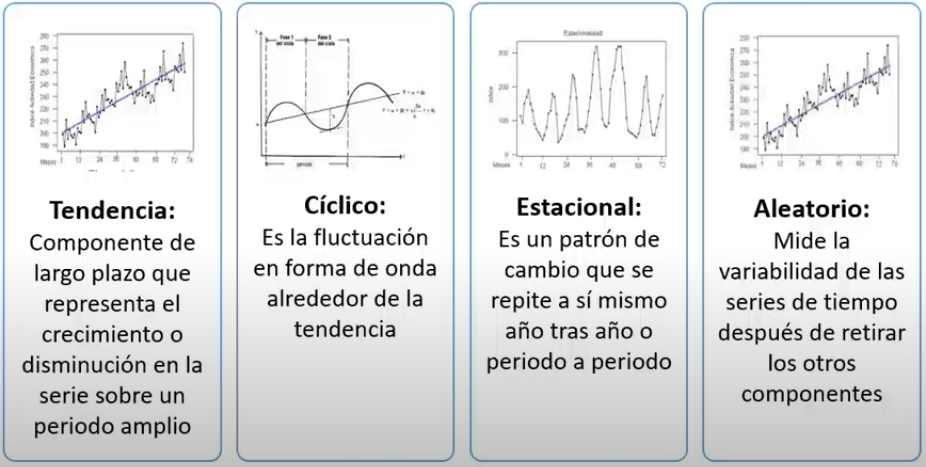

**La primera diferencia** de una serie temporal se calcula restando el valor de la serie en el tiempo ( 𝑡  ) del valor en el tiempo : 𝑡 − 1

Esta técnica se usa para hacer la serie más estacionaria, eliminando tendencias. Es simplemente la diferencia entre un valor en un momento dado y el valor inmediatamente anterior. Esta técnica se utiliza para estabilizar la media de una serie temporal, especialmente cuando la serie muestra tendencia.

**La función de autocorrelación** (ACF) mide la correlación de la serie con rezagos de sí misma.  Esto permite identificar si hay algún patrón repetitivo en los datos. Si la autocorrelación es alta para ciertos rezagos, sugiere que esos valores pasados influyen en los valores actuales.

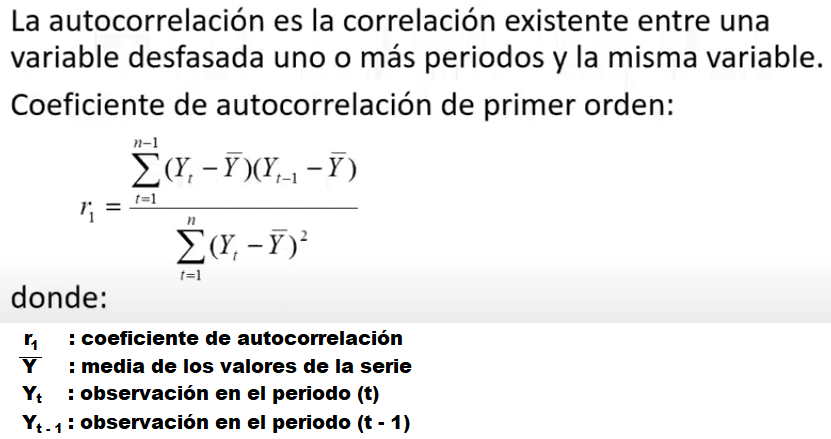

* Verificar Estacionalidad usando la Prueba de Dickey-Fuller Aumentada (ADF)

In [63]:
# 11
# Check si el proceso es estacionario

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])

ADF Statistic:  -1.4639255514154315
p-value:  0.5512754434013823
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Non-stationary 


* Tomando la Primera Diferencia y Rechecando la Estacionalidad
  - Interpretación:

Si la serie se vuelve estacionaria después de tomar la primera diferencia, significa que una tendencia lineal ha sido eliminada.

In [64]:
# Primera diferencia
# Eliminación de tendencias y estabilización de la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.370069834810996
p-value:  5.305870413780798e-23
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Stationary 


In [65]:
fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

* Verificar la autocorrelación en la serie temporal diferenciada.

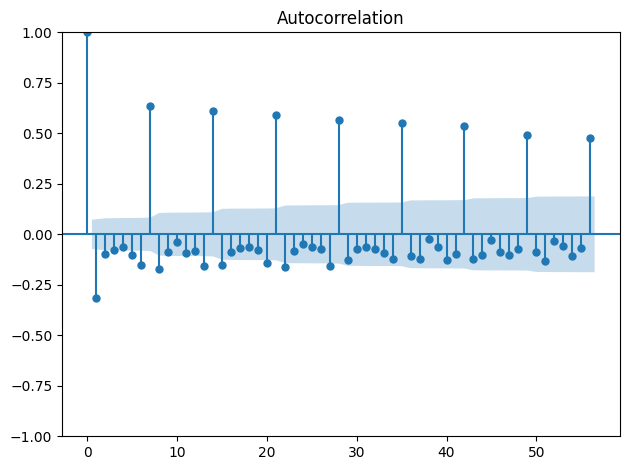

In [66]:
# En terminos generales, este gráfico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

### **Sin** aplicar la **primera diferencia** y creando nuevas columnas de fecha...

*  a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

* Análisis sin la Primera Diferencia y Creación de Nuevas Columnas de Fecha, para analizar patrones estacionales sin tomar la primera diferencia y capturar información de la fecha en diferentes niveles de granularidad.
  - Interpretación:

Estas nuevas columnas permiten agrupar y analizar los datos en diferentes periodos temporales para identificar patrones estacionales.

In [67]:
# 12

# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.dayofweek
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

* Visualización de Agrupaciones por Frecuencia

In [68]:
def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

In [69]:
# A nivel familia
graph_by_freq("dayofweek")

In [70]:
# A nivel articulo
graph_by_freq("dayofweek", "articulo")

In [71]:
# Gráficos caja x día de la semana

fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

## **2.3** Análisis **bivarial**

* ¿la "cantidad", en día festivo, es superior a cuando no lo es?

In [72]:
# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if pd.isna(x) else 1)
df['es_festivo'].value_counts()

es_festivo
0    9513
1     809
Name: count, dtype: int64

* el 7,84% de los días son festivos

In [73]:
fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

si las cantidades vendidas - en días festivos y no - son practicamente las mismas, hay un notable aumento de ventas en días festivos.

* la "cantidad", cuando llueve, es superior a cuando no llueve?

In [74]:
# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)
df["lluvia"].value_counts()

lluvia
0    9040
1    1282
Name: count, dtype: int64

* el 12,42% de los días fueron lluviosos

In [75]:
fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

si las cantidades vendidas - en días lluviosos y no - son practicamente las mismas, hay un notable aumento de ventas en días lluviosos.

División de la variable "tavg_w" en quintiles. Gráfico de barras para comparar sí la variable "cantidad" es superior en alguno de sus quintiles.

In [76]:
labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

* ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

In [77]:
def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

# **3.0** primera **manipulación** y modelado

## **3.1** inspección para un articulo en concreto
* creación de **itemDF**, esta instancia de creación será necesaria para la correcta ejecución de las instancias posteriores y no se puede prescindir de ella, como si de los futuros recortes ( instancia 3.2 en adelante )

In [78]:
df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('<M8[ns]'), dtype('float64'),
       UInt32Dtype(), dtype('int32'),
       CategoricalDtype(categories=['Temperatura muy baja', 'Temperatura baja',
                         'Temperatura normal', 'Temperatura alta',
                         'Temperatura muy alta'],
       , ordered=True)                                                         ],
      dtype=object)

In [79]:
print("pre drop: ",df.shape)
df[["familia","articulo"]].drop_duplicates().sort_values("familia").reset_index(drop=True)
print("post drop: ",df.shape)
df[["familia","articulo"]].head(3)

pre drop:  (10322, 23)
post drop:  (10322, 23)


,familia,articulo
0,BOLLERIA,3960
1,PANADERIA,1043
2,PANADERIA,968


In [80]:
family = "PANADERIA"
item = 900
meteovars = ["fecha_venta", "tavg_w", "lluvia", "isfestivo"]

# Filtrar y reiniciar el índice
itemDF = df.loc[(df["familia"] == family) & (df["articulo"] == item)].copy()

# Asegurarse de que la columna fecha_venta sea de tipo datetime
itemDF["fecha_venta"] = pd.to_datetime(itemDF["fecha_venta"])

# Ordenar por fecha_venta
itemDF.sort_values("fecha_venta", ascending=True, inplace=True)

# Resetear el índice
itemDF.reset_index(drop=True, inplace=True)

itemDF.head(3)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
0,PANADERIA,900,2021-05-01,NaN,0.87,651.00,563.11,3,17.20,11.90,...,14.20,1014.00,17,5,5,1,121,0,0,Temperatura baja
1,PANADERIA,900,2021-05-02,Día de la Madre,0.87,864.00,747.36,3,16.30,10.80,...,15.70,1015.90,17,5,6,2,122,1,0,Temperatura baja
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.87,555.00,480.08,3,15.30,12.70,...,9.70,1017.70,18,5,0,3,123,1,1,Temperatura baja


In [81]:
itemDF["lluvia"] = np.where(itemDF["prcp_w"] > 0, 1, 0)
itemDF.head(2)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
0,PANADERIA,900,2021-05-01,NaN,0.87,651.00,563.11,3,17.20,11.90,...,14.20,1014.00,17,5,5,1,121,0,0,Temperatura baja
1,PANADERIA,900,2021-05-02,Día de la Madre,0.87,864.00,747.36,3,16.30,10.80,...,15.70,1015.90,17,5,6,2,122,1,0,Temperatura baja


In [82]:
itemDF["festivo"].unique(), len(itemDF["festivo"].unique())

(array([nan, 'Día de la Madre', 'Día de la Cruz', 'Día de San Juan',
        'Día de la Virgen del Carmen', 'Día de la Victoria',
        'Fiesta de la Virgen de la Victoria',
        'Día de la Hispanidad (Fiesta Nacional de España)',
        'Noche de Halloween', 'Día de Todos los Santos',
        'Día de la Constitución', 'Nochebuena', 'Navidad', 'Nochevieja',
        'Año Nuevo', 'Día de Reyes', 'Día de San Valentín',
        'Día del Padre', 'Domingo de Ramos', 'Lunes Santo', 'Martes Santo',
        'Miércoles Santo', 'Jueves Santo', 'Viernes Santo', 'Sábado Santo',
        'Domingo de Resurrección', 'Feria de Málaga'], dtype=object),
 27)

* Otras fechas que podrían ser relevantes y no están en la lista:

  - Fiesta del Trabajo: 1 de mayo (aunque es nacional, puede ser relevante para el análisis)
  - Día de Andalucía: 28 de febrero (importante para toda la comunidad autónoma de Andalucía)

* Además, tener en cuenta que algunas fechas están equivocadas
  ( de acuerdo a la información que encuentro en google el día de la mádre es el 4 de mayo, no el 2, pero así figuran los datos en la base original por lo que a efectos de este estudio no serán modificados )

In [83]:
print(itemDF.loc[itemDF["fecha_venta"] == datetime.datetime(2021,12,8), "festivo"]) # Día de la inmaculada
print(itemDF.loc[itemDF["fecha_venta"] == datetime.datetime(2022,5,1), "festivo"]) # 1° mayo es día del trabajador
# print(itemDF.loc[itemDF["fecha_venta"] == datetime.datetime(2022,5,4), "festivo"]) # 4 mayo es día de la madre
print(itemDF.loc[itemDF["fecha_venta"] == datetime.datetime(2022,2,28), "festivo"]) # Día de Andalucía

221    NaN
Name: festivo, dtype: object
365    Día de la Madre
Name: festivo, dtype: object
303    NaN
Name: festivo, dtype: object


In [84]:
update_Dates = [[12, 8, "de la inmaculada"], [5, 1, "del trabajador"], [2, 28, "de Andalucía"]]

def updateDatesToDf(df,df_datetime_colName, toUpdate_colName, update_list):
  years = df[df_datetime_colName].dt.year.unique()

  for year in years:
    for date in update_list:
      fest_date = datetime.datetime(year, date[0], date[1])
      df.loc[itemDF[df_datetime_colName] == fest_date, toUpdate_colName] = f"Día {date[2]}"
  print("complete..")

updateDatesToDf(itemDF, "fecha_venta", "festivo", update_Dates)
itemDF["festivo"].unique(), len(itemDF["festivo"].unique())

complete..


(array(['Día del trabajador', 'Día de la Madre', 'Día de la Cruz', nan,
        'Día de San Juan', 'Día de la Virgen del Carmen',
        'Día de la Victoria', 'Fiesta de la Virgen de la Victoria',
        'Día de la Hispanidad (Fiesta Nacional de España)',
        'Noche de Halloween', 'Día de Todos los Santos',
        'Día de la Constitución', 'Día de la inmaculada', 'Nochebuena',
        'Navidad', 'Nochevieja', 'Año Nuevo', 'Día de Reyes',
        'Día de San Valentín', 'Día de Andalucía', 'Día del Padre',
        'Domingo de Ramos', 'Lunes Santo', 'Martes Santo',
        'Miércoles Santo', 'Jueves Santo', 'Viernes Santo', 'Sábado Santo',
        'Domingo de Resurrección', 'Feria de Málaga'], dtype=object),
 30)

In [85]:
itemDF.loc[itemDF["fecha_venta"] == datetime.datetime(2022,12,8)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
586,PANADERIA,900,2022-12-08,Día de la inmaculada,1.01,294.00,296.94,3,15.90,14.30,...,13.80,1007.20,49,12,3,8,342,0,1,Temperatura baja


In [86]:
f = list(itemDF["festivo"].dropna().unique())
itemDF["isfestivo"] = np.where(itemDF["festivo"].isin(f), 1, 0)
itemDF.head(4)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
0,PANADERIA,900,2021-05-01,Día del trabajador,0.87,651.00,563.11,3,17.20,11.90,...,1014.00,17,5,5,1,121,0,0,Temperatura baja,1
1,PANADERIA,900,2021-05-02,Día de la Madre,0.87,864.00,747.36,3,16.30,10.80,...,1015.90,17,5,6,2,122,1,0,Temperatura baja,1
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.87,555.00,480.08,3,15.30,12.70,...,1017.70,18,5,0,3,123,1,1,Temperatura baja,1
3,PANADERIA,900,2021-05-04,NaN,0.87,465.00,402.23,3,16.50,12.00,...,1018.00,18,5,1,4,124,0,0,Temperatura baja,0


In [87]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [88]:
fig = make_subplots(specs=[[{"secondary_y":True}]])

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["cantidad"], name="Cantidad vendida"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["isfestivo"], name="Día festivo"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["lluvia"], name="Día lluvioso"),
    secondary_y=True
)

fig.update_xaxes(title_text="Fecha")

fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Festivo", secondary_y=True)
fig.update_yaxes(title_text="lluvioso", secondary_y=True)
fig.update_yaxes(title_text="Temperatura", secondary_y=True)

fig.show()

In [89]:
fig = make_subplots(specs=[[{"secondary_y":True}]])

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["cantidad"], name="Cantidad vendida"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["tmin_w"], name="Temperatura mínima"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x=itemDF["fecha_venta"], y=itemDF["tavg_w"], name="Temperatura"),
    secondary_y=True
)

fig.update_xaxes(title_text="Fecha")

fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Temperatura", secondary_y=True)
fig.update_yaxes(title_text="Temperatura mínima", secondary_y=True)

fig.show()

## **3.2** recorte de dicho articulo
* RECORTE en base a fecha: 2023 / 3 / 1
* creación de **itemSales**

In [90]:
itemSales = itemDF.loc[itemDF["fecha_venta"] < datetime.datetime(2023,3,1)]
itemSalesTest = itemDF.loc[itemDF["fecha_venta"] >= datetime.datetime(2023,3,1)]

print(itemSales.shape)
itemSales.head(3)

(669, 24)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
0,PANADERIA,900,2021-05-01,Día del trabajador,0.87,651.00,563.11,3,17.20,11.90,...,1014.00,17,5,5,1,121,0,0,Temperatura baja,1
1,PANADERIA,900,2021-05-02,Día de la Madre,0.87,864.00,747.36,3,16.30,10.80,...,1015.90,17,5,6,2,122,1,0,Temperatura baja,1
2,PANADERIA,900,2021-05-03,Día de la Cruz,0.87,555.00,480.08,3,15.30,12.70,...,1017.70,18,5,0,3,123,1,1,Temperatura baja,1


In [91]:
print(itemSalesTest.shape)
itemSalesTest.tail(3)

(61, 24)


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
727,PANADERIA,900,2023-04-28,NaN,1.05,186.00,195.30,3,20.80,16.60,...,1015.20,17,4,4,28,118,0,0,Temperatura normal,0
728,PANADERIA,900,2023-04-29,NaN,1.05,462.00,485.10,3,25.60,18.70,...,1015.40,17,4,5,29,119,0,0,Temperatura muy alta,0
729,PANADERIA,900,2023-04-30,NaN,1.05,216.00,226.80,3,23.10,18.20,...,1014.90,17,4,6,30,120,0,0,Temperatura alta,0


In [92]:
itemSales.set_index("fecha_venta", inplace=True)
itemSalesTest.set_index("fecha_venta", inplace=True)

itemSalesComplete = itemSales.resample("1D").last()
itemSalesTestComplete = itemSalesTest.resample("1D").last()
print(itemSalesComplete.shape)
itemSalesComplete.head(3)

(669, 23)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
fecha_venta,,,,,,,,,,,,,,,,,,,,,
2021-05-01,PANADERIA,900,Día del trabajador,0.87,651.00,563.11,3,17.20,11.90,22.80,...,1014.00,17,5,5,1,121,0,0,Temperatura baja,1
2021-05-02,PANADERIA,900,Día de la Madre,0.87,864.00,747.36,3,16.30,10.80,23.20,...,1015.90,17,5,6,2,122,1,0,Temperatura baja,1
2021-05-03,PANADERIA,900,Día de la Cruz,0.87,555.00,480.08,3,15.30,12.70,20.10,...,1017.70,18,5,0,3,123,1,1,Temperatura baja,1


In [93]:
print(itemSalesTestComplete.shape)
itemSalesTestComplete.tail(3)

(61, 23)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
fecha_venta,,,,,,,,,,,,,,,,,,,,,
2023-04-28,PANADERIA,900,None,1.05,186.00,195.30,3,20.80,16.60,26.70,...,1015.20,17,4,4,28,118,0,0,Temperatura normal,0
2023-04-29,PANADERIA,900,None,1.05,462.00,485.10,3,25.60,18.70,34.30,...,1015.40,17,4,5,29,119,0,0,Temperatura muy alta,0
2023-04-30,PANADERIA,900,None,1.05,216.00,226.80,3,23.10,18.20,27.70,...,1014.90,17,4,6,30,120,0,0,Temperatura alta,0


* No hay datos de fechas faltantes, ambas series están completas

  - **itemSalesComplete**: Este DF representará los datos de entrenamiento referentes a un único articulo (de una única familia)
  - **itemSalesTestComplete**: Este DF contiene los datos reales de los ultimos meses registrados en la base de datos, sobre los cuales se predecirán valores futuros

## **3.3** Conversión a **aprendizaje supervisado**

* **itemSalesSuperviced** aplica la fución de supervisación *series_to_supervised()* para incorporar las correlaciones temporales:
      var1(t-2 day)	var1(t-1 day)	var1(t-1 week)	var1(t)

In [94]:
print("item sales shape: ",itemSales.shape)
itemSalesSuperviced = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily=2, n_in_weekly=1, n_out=1, dropnan=True)
itemSalesSuperviced.reset_index(inplace=True)
print("item sales superviced shape: ",itemSalesSuperviced.shape)
itemSalesSuperviced

item sales shape:  (669, 23)
item sales superviced shape:  (662, 5)


,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t)
0,2021-05-08,486.00,576.00,651.00,852.00
1,2021-05-09,576.00,852.00,864.00,702.00
2,2021-05-10,852.00,702.00,555.00,396.00
3,2021-05-11,702.00,396.00,465.00,525.00
4,2021-05-12,396.00,525.00,432.00,459.00
...,...,...,...,...,...
657,2023-02-24,357.00,156.00,333.00,324.00
658,2023-02-25,156.00,324.00,276.00,321.00
659,2023-02-26,324.00,321.00,468.00,408.00
660,2023-02-27,321.00,408.00,372.00,414.00


In [95]:
itemSales.reset_index(inplace=True) # Se requiere la columna 'fecha_ventas' disponible para hacer el merge
itemSalesSuperviced = itemSalesSuperviced.merge(itemSales[meteovars], on="fecha_venta", how="inner")
itemSalesSuperviced

,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo
0,2021-05-08,486.00,576.00,651.00,852.00,20.40,1,0
1,2021-05-09,576.00,852.00,864.00,702.00,19.40,0,0
2,2021-05-10,852.00,702.00,555.00,396.00,17.30,1,0
3,2021-05-11,702.00,396.00,465.00,525.00,18.60,0,0
4,2021-05-12,396.00,525.00,432.00,459.00,21.90,0,0
...,...,...,...,...,...,...,...,...
657,2023-02-24,357.00,156.00,333.00,324.00,12.00,1,0
658,2023-02-25,156.00,324.00,276.00,321.00,10.60,0,0
659,2023-02-26,324.00,321.00,468.00,408.00,12.40,0,0
660,2023-02-27,321.00,408.00,372.00,414.00,12.70,0,0


In [96]:
itemSalesSuperviced['day'] = itemSalesSuperviced['fecha_venta'].dt.day
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['fecha_venta'].dt.dayofweek
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['dayofweek'] + 1
itemSalesSuperviced['month'] = itemSalesSuperviced['fecha_venta'].dt.month
itemSalesSuperviced['year'] = itemSalesSuperviced['fecha_venta'].dt.year
itemSalesSuperviced['weekday'] = itemSalesSuperviced['dayofweek'] < 6

itemSalesSuperviced

,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
0,2021-05-08,486.00,576.00,651.00,852.00,20.40,1,0,8,6,5,2021,False
1,2021-05-09,576.00,852.00,864.00,702.00,19.40,0,0,9,7,5,2021,False
2,2021-05-10,852.00,702.00,555.00,396.00,17.30,1,0,10,1,5,2021,True
3,2021-05-11,702.00,396.00,465.00,525.00,18.60,0,0,11,2,5,2021,True
4,2021-05-12,396.00,525.00,432.00,459.00,21.90,0,0,12,3,5,2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,2023-02-24,357.00,156.00,333.00,324.00,12.00,1,0,24,5,2,2023,True
658,2023-02-25,156.00,324.00,276.00,321.00,10.60,0,0,25,6,2,2023,False
659,2023-02-26,324.00,321.00,468.00,408.00,12.40,0,0,26,7,2,2023,False
660,2023-02-27,321.00,408.00,372.00,414.00,12.70,0,0,27,1,2,2023,True


In [97]:
itemSalesSuperviced["weekday"] = lb.fit_transform(itemSalesSuperviced["weekday"])
itemSalesSuperviced.head(2)

,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
0,2021-05-08,486.00,576.00,651.00,852.00,20.40,1,0,8,6,5,2021,0
1,2021-05-09,576.00,852.00,864.00,702.00,19.40,0,0,9,7,5,2021,0


In [98]:
itemSalesSuperviced.reset_index(drop=True, inplace=True)
itemSalesSuperviced.head(2)

,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
0,2021-05-08,486.00,576.00,651.00,852.00,20.40,1,0,8,6,5,2021,0
1,2021-05-09,576.00,852.00,864.00,702.00,19.40,0,0,9,7,5,2021,0


In [99]:
testrate = 0.05
size = int((1-testrate)*len(itemSalesSuperviced))

Data_train = itemSalesSuperviced.loc[0:(size-1),:]
Data_test = itemSalesSuperviced.loc[size:,:]
testDates = Data_test["fecha_venta"].to_list()

In [100]:
print(Data_train.shape)
Data_train.head(3)

(628, 13)


,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
0,2021-05-08,486.00,576.00,651.00,852.00,20.40,1,0,8,6,5,2021,0
1,2021-05-09,576.00,852.00,864.00,702.00,19.40,0,0,9,7,5,2021,0
2,2021-05-10,852.00,702.00,555.00,396.00,17.30,1,0,10,1,5,2021,1


In [101]:
print(Data_test.shape)
Data_test.head(3)

(34, 13)


,fecha_venta,var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
628,2023-01-26,420.00,399.00,351.00,180.00,9.70,0,0,26,4,1,2023,1
629,2023-01-27,399.00,180.00,363.00,297.00,10.20,0,0,27,5,1,2023,1
630,2023-01-28,180.00,297.00,462.00,342.00,9.20,0,0,28,6,1,2023,0


* escalamiento

In [102]:
dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

In [103]:
dfTrain_scaled[["var1(t)","var1(t)_scld"]]

,var1(t),var1(t)_scld
0,852.00,0.74
1,702.00,0.59
2,396.00,0.28
3,525.00,0.41
4,459.00,0.35
...,...,...
623,462.00,0.35
624,549.00,0.44
625,423.00,0.31
626,420.00,0.31


In [104]:
dfTrain_scaled.columns

Index(['fecha_venta', 'var1(t-2 day)', 'var1(t-1 day)', 'var1(t-1 week)',
       'var1(t)', 'tavg_w', 'lluvia', 'isfestivo', 'day', 'dayofweek', 'month',
       'year', 'weekday', 'var1(t-2 day)_scld', 'var1(t-1 day)_scld',
       'var1(t-1 week)_scld', 'var1(t)_scld', 'tavg_w_scld', 'lluvia_scld',
       'isfestivo_scld', 'day_scld', 'dayofweek_scld', 'month_scld',
       'year_scld', 'weekday_scld'],
      dtype='object')

In [105]:
varcols = ['var1(t-2 day)_scld', 'var1(t-1 day)_scld',
       'var1(t-1 week)_scld',  'tavg_w_scld', 'lluvia_scld',
       'isfestivo_scld', 'day_scld', 'dayofweek_scld', 'month_scld',
       'year_scld', 'weekday_scld']
label = ['var1(t)_scld']

X_train = np.array(dfTrain_scaled[varcols])
Y_train = np.array(dfTrain_scaled[label])

X_test = np.array(dfTest_scaled[varcols])
Y_test = np.array(dfTest_scaled[label])

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

data = (X_train, Y_train, X_test, Y_test)

(628, 11) (628, 1) (34, 11) (34, 1)


## **3.4** ejecución de modelos *con parametrizado simple* para primer articulo
* mejores resultados:


                        Mean_AE	Mean_SE	Median_AE
      AdaBoost	        0.1579	0.0437	0.1225
      LinearRegression	0.1793	0.0450	0.1737
      Ridge	           0.1805	0.0457	0.1741

In [106]:
results = basic_modelMetrics_compared_ts(data, models, simple_model_params)
results

Mejor modelo basado en CV: RandomForest con CV_Mean_AE: 0.10132211742206923


(              model  CV_Mean_AE  Mean_AE  Mean_SE  Median_AE
 0      RandomForest        0.10     0.21     0.07       0.16
 4             Ridge        0.10     0.21     0.07       0.17
 3  LinearRegression        0.10     0.21     0.07       0.17
 8               SVR        0.11     0.22     0.07       0.20
 1  GradientBoosting        0.11     0.20     0.06       0.14
 7        KNeighbors        0.11     0.21     0.07       0.16
 2          AdaBoost        0.12     0.20     0.06       0.15
 6         ExtraTree        0.13     0.28     0.12       0.24
 5      DecisionTree        0.14     0.33     0.15       0.27,
 RandomForestRegressor(random_state=42))

* se inspeccionaran en detalle AdaBoost, GradientBoosting y LinearRegression dado que tienen los mejores puntajes, aprox:

                          Mean_AE	Mean_SE	Median_AE
          	AdaBoost	0.2022	0.0687	0.1688
	  GradientBoosting	0.2037	0.0630	0.1620
	  LinearRegression	0.2091	0.0663	0.1717

### Ada Boost

mejor desempeño con **hiperparametros:** {'n_estimators': 100, 'learning_rate': 1.0}

  - promedio de diferencia: 40.84375
  - Metricas de predicción - real: -MSE : 11411.34375 ; MAE : 78.65625 ; error ACC:
2517.0

* **AdaBoostRegressor()** sin hiper parámetros

Metricas de predicción - real

  - --MSE :
11310.28125

  - --MAE :
82.40625

  - -Error ACC :
2637.0

promedio de diferencia: 48.34375

para el modelo AdaBoostRegressor()
Metricas de predicción - real
--M Squared E
7806.176470588235
--M Absolute E
69.52941176470588
-Error acumulado
2364.0


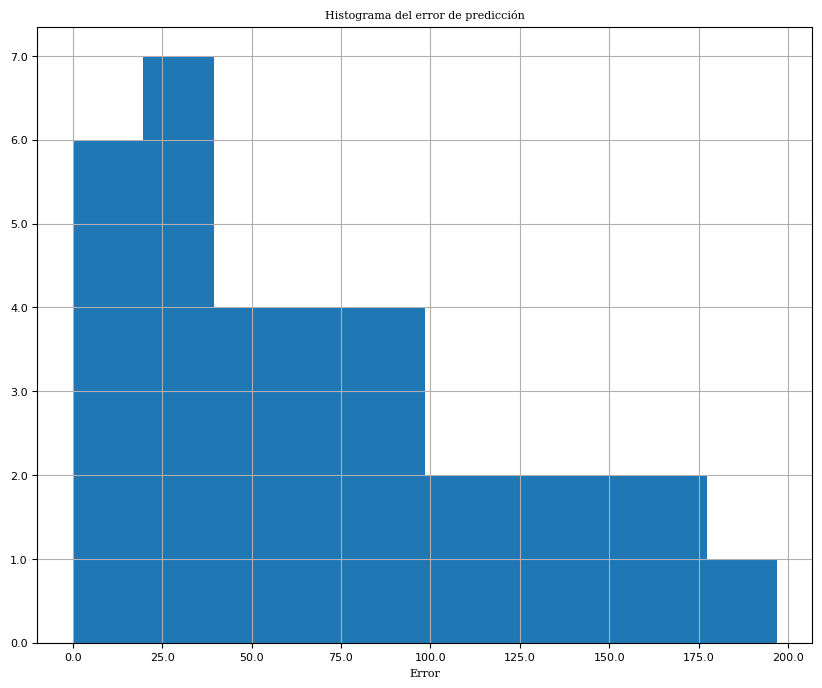

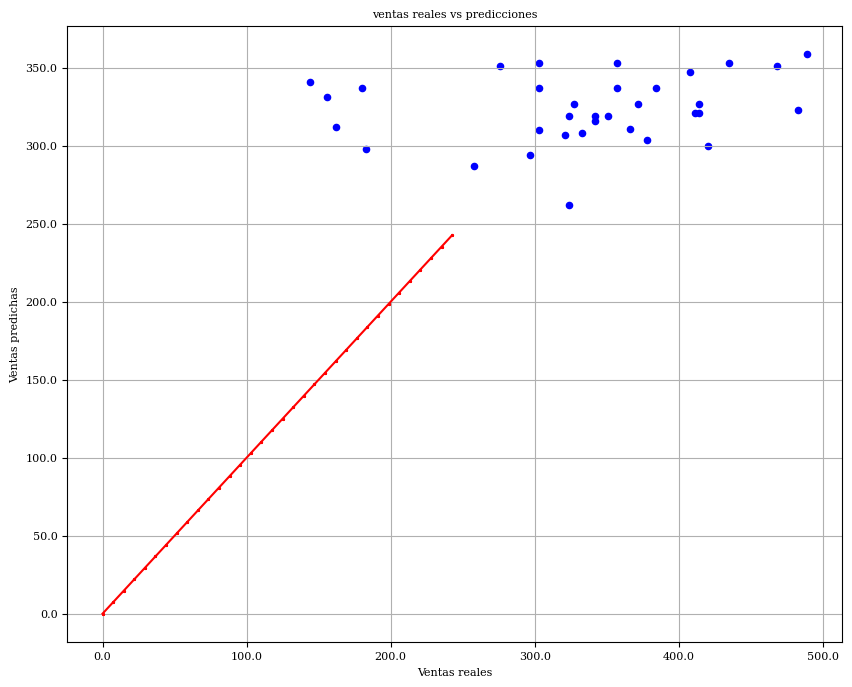

In [107]:
model=AdaBoostRegressor()
comparison = singleResultsAndPlots(model, data)

In [108]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 69.52941176470588


,venta real,venta predicha ML,fecha,diff,line,line2
0,180.00,337,2023-01-26,157.00,0.00,0.00
1,297.00,294,2023-01-27,3.00,7.35,7.35
2,342.00,316,2023-01-28,26.00,14.71,14.71
3,435.00,353,2023-01-29,82.00,22.06,22.06
4,327.00,327,2023-01-30,0.00,29.41,29.41
5,366.00,311,2023-01-31,55.00,36.76,36.76
6,414.00,327,2023-02-01,87.00,44.12,44.12
7,144.00,341,2023-02-02,197.00,51.47,51.47
8,324.00,262,2023-02-03,62.00,58.82,58.82
9,378.00,304,2023-02-04,74.00,66.18,66.18


**AdaBoostRegressor** con hiper parámetros simples:
    
    {'n_estimators': 100, 'learning_rate': 1.0}

promedio de diferencia: 40.84375

In [109]:
model=AdaBoostRegressor(**simple_model_params["AdaBoost"])
comparison = singleResultsAndPlots(model, data, plotAll=False)

para el modelo AdaBoostRegressor(n_estimators=100)
Metricas de predicción - real
--M Squared E
8410.941176470587
--M Absolute E
72.23529411764706
-Error acumulado
2456.0


In [110]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 72.23529411764706


,venta real,venta predicha ML,fecha,diff
0,180.00,348,2023-01-26,168.00
1,297.00,288,2023-01-27,9.00
2,342.00,297,2023-01-28,45.00
3,435.00,341,2023-01-29,94.00
4,327.00,325,2023-01-30,2.00
5,366.00,309,2023-01-31,57.00
6,414.00,319,2023-02-01,95.00
7,144.00,363,2023-02-02,219.00
8,324.00,275,2023-02-03,49.00
9,378.00,297,2023-02-04,81.00


### Gradient Boosting Regressor
Metricas de predicción - real

  - --MSE :
11667.3125

  - --MAE :
91.3125

  - --Error ACC :
2922.0

promedio de diferencia: 55.5

para el modelo GradientBoostingRegressor()
Metricas de predicción - real
--M Squared E
7552.382352941177
--M Absolute E
70.73529411764706
-Error acumulado
2405.0


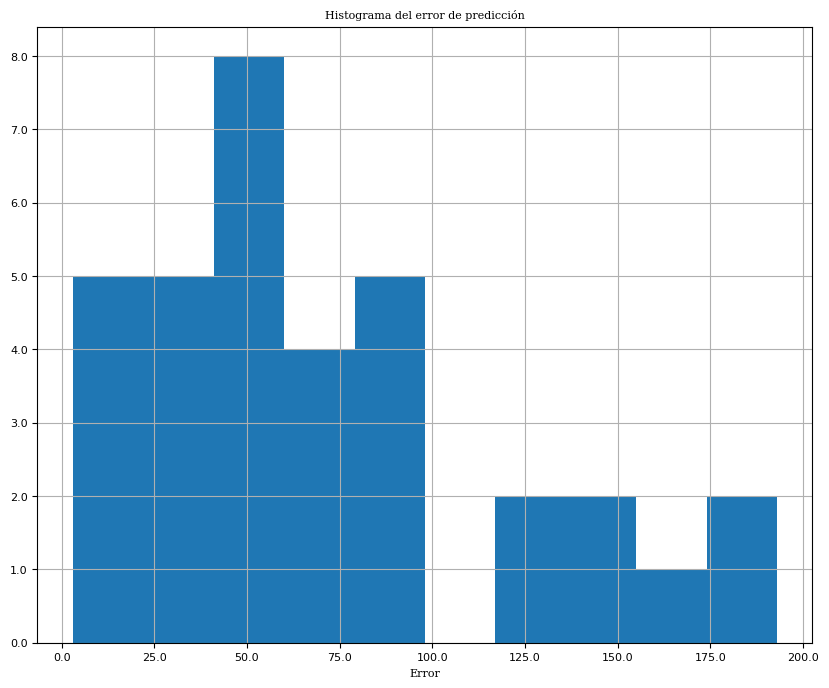

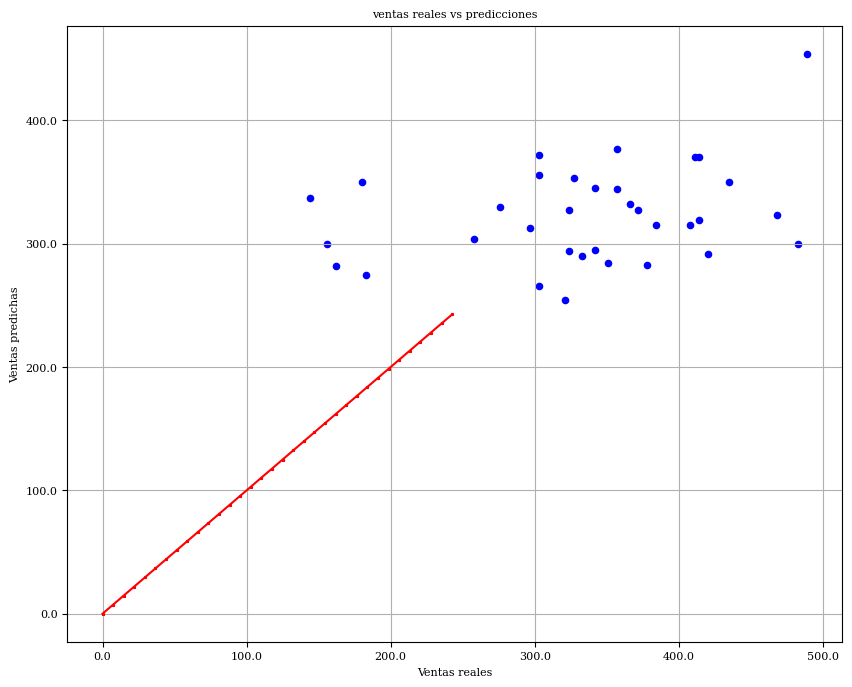

In [111]:
model=GradientBoostingRegressor()
comparison = singleResultsAndPlots(model, data)

In [112]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison.head(3)

promedio de diferencia: 70.73529411764706


,venta real,venta predicha ML,fecha,diff,line,line2
0,180.00,350,2023-01-26,170.00,0.00,0.00
1,297.00,313,2023-01-27,16.00,7.35,7.35
2,342.00,295,2023-01-28,47.00,14.71,14.71


### Linear Regression

Metricas de predicción - real

  - --MSE : 11492.125

  - --MAE :
90.6875

  - -Error ACC :
2902.0

promedio de diferencia: 53.8125

para el modelo LinearRegression()
Metricas de predicción - real
--M Squared E
7924.911764705882
--M Absolute E
72.38235294117646
-Error acumulado
2461.0


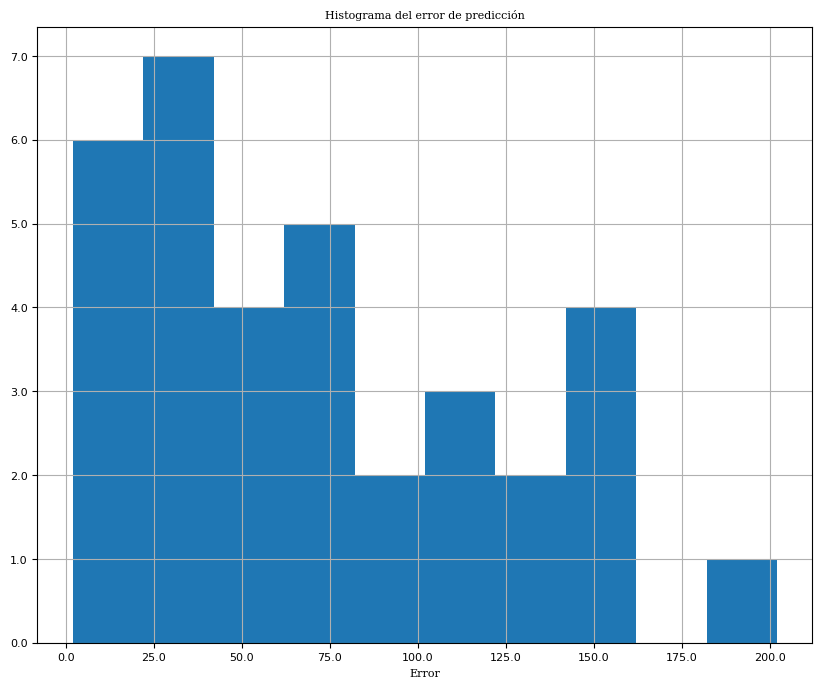

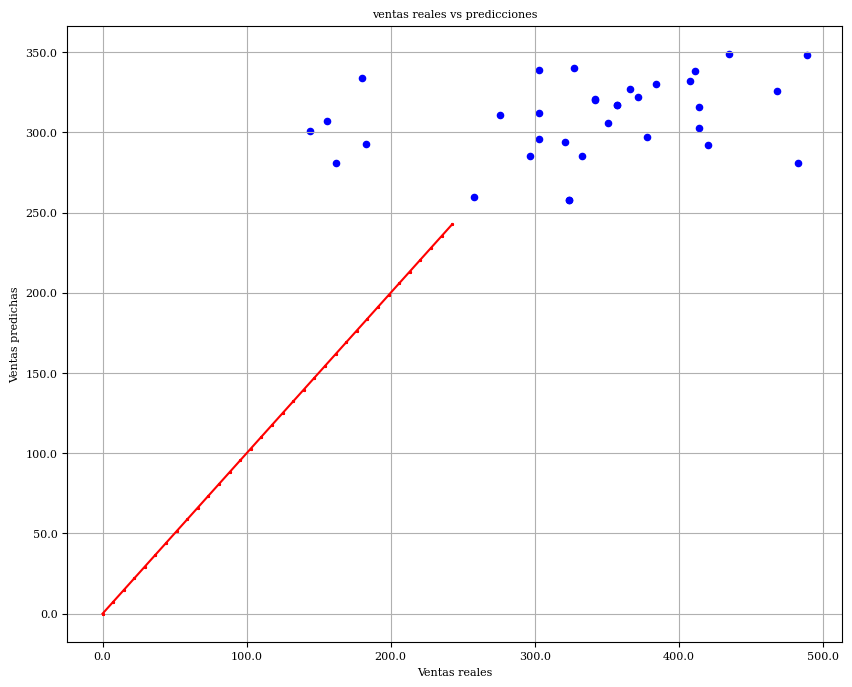

In [113]:
model= LinearRegression()
comparison = singleResultsAndPlots(model, data)

In [114]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison.head(3)

promedio de diferencia: 72.38235294117646


,venta real,venta predicha ML,fecha,diff,line,line2
0,180.00,334,2023-01-26,154.00,0.00,0.00
1,297.00,285,2023-01-27,12.00,7.35,7.35
2,342.00,321,2023-01-28,21.00,14.71,14.71


## **3.6** nuevo recorte de dicho articulo
* A diferencia de la instancía **3.2**, este nuevo RECORTE será en base a un Día de la semana: Martes

* situación a resolver: se debería recortar por día de la semana, mes o año? se debería diferenciar entre día laboral (de semana) y fin de semana? se debería diferenciar entre días normales y festivos?

In [115]:
Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday = 7 , 1 , 2 , 3 , 4 , 5 , 6
itemSales = itemDF.loc[itemDF["fecha_venta"] < datetime.datetime(2023,3,1)]
itemSalesTest = itemDF.loc[itemDF["fecha_venta"] >= datetime.datetime(2023,3,1)]

print(f"itemSales.shape : {itemSales.shape},  itemSalesTest.shape : {itemSalesTest.shape}")

itemSales.set_index("fecha_venta", inplace=True)
itemSalesTest.set_index("fecha_venta", inplace=True)

itemSalesComplete = itemSales.resample("1D").last()
itemSalesTestComplete = itemSalesTest.resample("1D").last()

print("item sales shape with set_index: ",itemSales.shape)
itemSalesSuperviced = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily=5, n_in_weekly=0, n_out=1, dropnan=True)
itemSalesSuperviced.reset_index(inplace=True)
print("item sales superviced shape: ",itemSalesSuperviced.shape)

itemSales.reset_index(inplace=True) # Se requiere la columna 'fecha_ventas' disponible para hacer el merge
itemSalesSuperviced = itemSalesSuperviced.merge(itemSales[meteovars], on="fecha_venta", how="inner")
print("item sales superviced -with meteorologic vars- shape: ",itemSalesSuperviced.shape)

itemSalesSuperviced['day'] = itemSalesSuperviced['fecha_venta'].dt.day
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['fecha_venta'].dt.dayofweek
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['dayofweek'] + 1
itemSalesSuperviced['month'] = itemSalesSuperviced['fecha_venta'].dt.month
itemSalesSuperviced['year'] = itemSalesSuperviced['fecha_venta'].dt.year
itemSalesSuperviced['weekday'] = itemSalesSuperviced['dayofweek'] < 6

itemSalesSuperviced["weekday"] = lb.fit_transform(itemSalesSuperviced["weekday"])

itemSalesSuperviced = itemSalesSuperviced.loc[itemSalesSuperviced["dayofweek"] == Tuesday]
itemSalesSuperviced.reset_index(drop=True, inplace=True)

print("\n",itemSalesSuperviced.shape)
itemSalesSuperviced.head()

itemSales.shape : (669, 24),  itemSalesTest.shape : (61, 24)
item sales shape with set_index:  (669, 23)
item sales superviced shape:  (664, 7)
item sales superviced -with meteorologic vars- shape:  (664, 10)

 (95, 15)


,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,day,dayofweek,month,year,weekday
0,2021-05-11,486.00,576.00,852.00,702.00,396.00,525.00,18.60,0,0,11,2,5,2021,1
1,2021-05-18,732.00,405.00,429.00,609.00,543.00,423.00,19.80,0,0,18,2,5,2021,1
2,2021-05-25,681.00,381.00,516.00,675.00,486.00,591.00,19.30,0,0,25,2,5,2021,1
3,2021-06-01,540.00,552.00,795.00,540.00,591.00,567.00,23.20,0,0,1,2,6,2021,1
4,2021-06-08,657.00,567.00,558.00,936.00,588.00,714.00,22.80,0,0,8,2,6,2021,1


In [116]:
testrate = 0.15
size = int((1-testrate)*len(itemSalesSuperviced))

Data_train = itemSalesSuperviced.loc[0:(size-1),:]
Data_test = itemSalesSuperviced.loc[size:,:]
testDates = Data_test["fecha_venta"].to_list()

print(f"Data_train: {Data_train.shape}, Data_test: {Data_test.shape}, testDates: {len(testDates)}\n")

dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

dfTrain_scaled

Data_train: (80, 15), Data_test: (15, 15), testDates: 15



,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,...,var1(t-1 day)_scld,var1(t)_scld,tavg_w_scld,lluvia_scld,isfestivo_scld,day_scld,dayofweek_scld,month_scld,year_scld,weekday_scld
0,2021-05-11,486.00,576.00,852.00,702.00,396.00,525.00,18.60,0,0,...,0.33,0.48,0.37,0.00,0.00,0.33,0.00,0.36,0.00,0.00
1,2021-05-18,732.00,405.00,429.00,609.00,543.00,423.00,19.80,0,0,...,0.50,0.35,0.43,0.00,0.00,0.57,0.00,0.36,0.00,0.00
2,2021-05-25,681.00,381.00,516.00,675.00,486.00,591.00,19.30,0,0,...,0.44,0.57,0.40,0.00,0.00,0.80,0.00,0.36,0.00,0.00
3,2021-06-01,540.00,552.00,795.00,540.00,591.00,567.00,23.20,0,0,...,0.56,0.54,0.59,0.00,0.00,0.00,0.00,0.45,0.00,0.00
4,2021-06-08,657.00,567.00,558.00,936.00,588.00,714.00,22.80,0,0,...,0.56,0.73,0.57,0.00,0.00,0.23,0.00,0.45,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2022-10-18,393.00,396.00,165.00,609.00,336.00,396.00,22.10,0,0,...,0.26,0.31,0.53,0.00,0.00,0.57,0.00,0.82,1.00,0.00
76,2022-10-25,354.00,294.00,351.00,501.00,219.00,408.00,20.90,0,0,...,0.12,0.33,0.48,0.00,0.00,0.80,0.00,0.82,1.00,0.00
77,2022-11-01,315.00,267.00,363.00,537.00,465.00,588.00,19.70,0,1,...,0.41,0.57,0.42,0.00,1.00,0.00,0.00,0.91,1.00,0.00
78,2022-11-08,375.00,387.00,324.00,486.00,453.00,234.00,16.40,0,0,...,0.40,0.10,0.27,0.00,0.00,0.23,0.00,0.91,1.00,0.00


In [117]:
print(dfTrain_scaled.columns)

Index(['fecha_venta', 'var1(t-5 day)', 'var1(t-4 day)', 'var1(t-3 day)',
       'var1(t-2 day)', 'var1(t-1 day)', 'var1(t)', 'tavg_w', 'lluvia',
       'isfestivo', 'day', 'dayofweek', 'month', 'year', 'weekday',
       'var1(t-5 day)_scld', 'var1(t-4 day)_scld', 'var1(t-3 day)_scld',
       'var1(t-2 day)_scld', 'var1(t-1 day)_scld', 'var1(t)_scld',
       'tavg_w_scld', 'lluvia_scld', 'isfestivo_scld', 'day_scld',
       'dayofweek_scld', 'month_scld', 'year_scld', 'weekday_scld'],
      dtype='object')


In [118]:
varcols = ['var1(t-5 day)_scld', 'var1(t-4 day)_scld', 'var1(t-3 day)_scld',
       'var1(t-2 day)_scld', 'var1(t-1 day)_scld',
       'tavg_w_scld', 'lluvia_scld', 'isfestivo_scld', 'day_scld',
       'month_scld', 'year_scld']
label = ['var1(t)_scld']

dfTrain_scaled[varcols].describe()

,var1(t-5 day)_scld,var1(t-4 day)_scld,var1(t-3 day)_scld,var1(t-2 day)_scld,var1(t-1 day)_scld,tavg_w_scld,lluvia_scld,isfestivo_scld,day_scld,month_scld,year_scld
count,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00,80.00
mean,0.39,0.37,0.37,0.37,0.44,0.46,0.17,0.06,0.49,0.55,0.57
std,0.20,0.19,0.20,0.20,0.16,0.24,0.38,0.24,0.29,0.28,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.28,0.25,0.25,0.25,0.32,0.24,0.00,0.00,0.23,0.36,0.00
50%,0.34,0.35,0.32,0.33,0.43,0.48,0.00,0.00,0.47,0.55,1.00
75%,0.48,0.46,0.47,0.47,0.54,0.66,0.00,0.00,0.73,0.75,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [119]:
X_train = np.array(dfTrain_scaled[varcols])
Y_train = np.array(dfTrain_scaled[label])

X_test = np.array(dfTest_scaled[varcols])
Y_test = np.array(dfTest_scaled[label])

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(80, 11) (80, 1) (15, 11) (15, 1)


In [120]:
checkNullColumns(dfTest_scaled[varcols])

Nulls in all columns:
var1(t-5 day)_scld: 0 (0.0%)
var1(t-4 day)_scld: 0 (0.0%)
var1(t-3 day)_scld: 0 (0.0%)
var1(t-2 day)_scld: 0 (0.0%)
var1(t-1 day)_scld: 0 (0.0%)
tavg_w_scld: 0 (0.0%)
lluvia_scld: 0 (0.0%)
isfestivo_scld: 0 (0.0%)
day_scld: 0 (0.0%)
month_scld: 0 (0.0%)
year_scld: 0 (0.0%)


In [121]:
dfTrain_scaled[["var1(t)","var1(t)_scld"]]

,var1(t),var1(t)_scld
0,525.00,0.48
1,423.00,0.35
2,591.00,0.57
3,567.00,0.54
4,714.00,0.73
...,...,...
75,396.00,0.31
76,408.00,0.33
77,588.00,0.57
78,234.00,0.10


In [122]:
data = (X_train, Y_train, X_test, Y_test)
results, best_model = basic_modelMetrics_compared_ts(data, models, simple_model_params)

results

Mejor modelo basado en CV: Ridge con CV_Mean_AE: 0.12995063155222003


,model,CV_Mean_AE,Mean_AE,Mean_SE,Median_AE
4,Ridge,0.13,0.32,0.12,0.26
7,KNeighbors,0.13,0.29,0.11,0.28
0,RandomForest,0.14,0.31,0.13,0.32
3,LinearRegression,0.14,0.35,0.15,0.28
2,AdaBoost,0.15,0.33,0.14,0.33
8,SVR,0.15,0.29,0.11,0.26
1,GradientBoosting,0.16,0.33,0.15,0.32
6,ExtraTree,0.17,0.30,0.13,0.25
5,DecisionTree,0.20,0.34,0.18,0.18


                  	Mean_AE	Mean_SE	Median_AE
    LinearRegression	0.0000	0.0000	0.0000

para el modelo Ridge()
Metricas de predicción - real
--M Squared E
37801.26666666667
--M Absolute E
177.53333333333333
-Error acumulado
2663.0


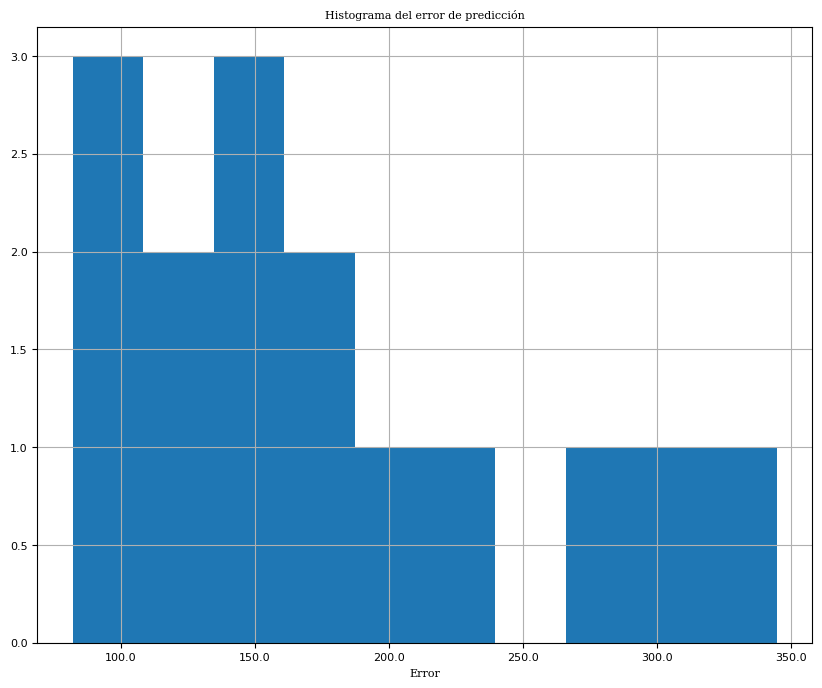

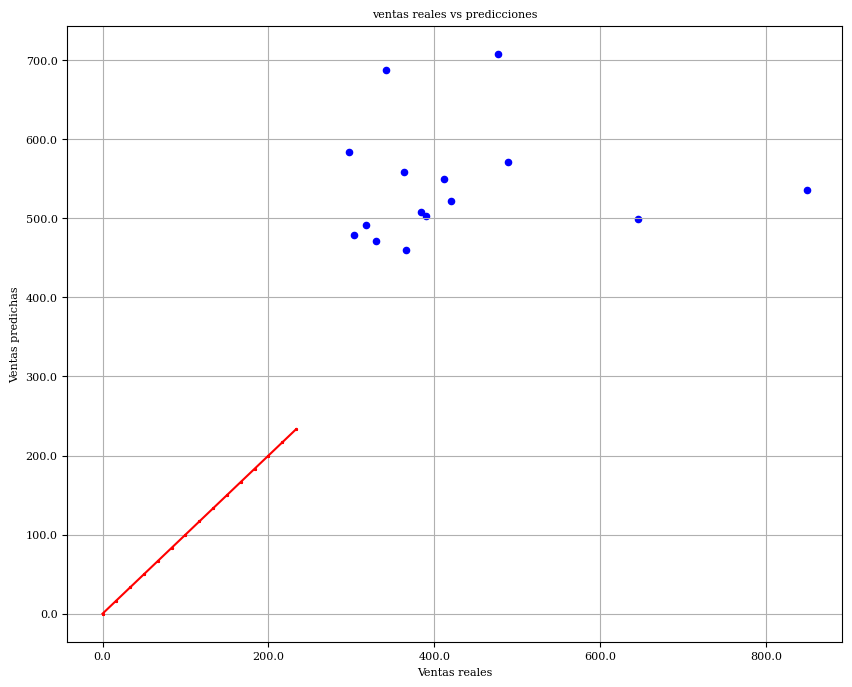

In [123]:
data = (X_train, Y_train, X_test, Y_test)
model=best_model
comparison = singleResultsAndPlots(model, data)

In [124]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 177.53333333333333


,venta real,venta predicha ML,fecha,diff,line,line2
0,342.00,687,2022-11-22,345.00,0.00,0.00
1,330.00,471,2022-11-29,141.00,16.67,16.67
2,477.00,708,2022-12-06,231.00,33.33,33.33
3,297.00,584,2022-12-13,287.00,50.00,50.00
4,390.00,503,2022-12-20,113.00,66.67,66.67
5,849.00,536,2022-12-27,313.00,83.33,83.33
6,645.00,499,2023-01-03,146.00,100.00,100.00
7,318.00,492,2023-01-10,174.00,116.67,116.67
8,363.00,559,2023-01-17,196.00,133.33,133.33
9,420.00,522,2023-01-24,102.00,150.00,150.00


* Independientemente del éxito del modelo de regresión lineal con el nuevo recorte se compararán 2 modelos predictivos mas solo para estar seguros de que las predicciones están funcionando correctamente

In [125]:
model=AdaBoostRegressor(**simple_model_params["AdaBoost"])
comparison = singleResultsAndPlots(model, data, plotAll=False)

para el modelo AdaBoostRegressor(n_estimators=100)
Metricas de predicción - real
--M Squared E
40173.933333333334
--M Absolute E
173.13333333333333
-Error acumulado
2597.0


In [126]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 173.13333333333333


,venta real,venta predicha ML,fecha,diff
0,342.00,785,2022-11-22,443.00
1,330.00,460,2022-11-29,130.00
2,477.00,647,2022-12-06,170.00
3,297.00,565,2022-12-13,268.00
4,390.00,512,2022-12-20,122.00
5,849.00,744,2022-12-27,105.00
6,645.00,417,2023-01-03,228.00
7,318.00,574,2023-01-10,256.00
8,363.00,590,2023-01-17,227.00
9,420.00,590,2023-01-24,170.00


In [127]:
model= GradientBoostingRegressor()
comparison = singleResultsAndPlots(model, data, plotAll=False)

para el modelo GradientBoostingRegressor()
Metricas de predicción - real
--M Squared E
46248.0
--M Absolute E
182.4
-Error acumulado
2736.0


In [128]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 182.4


,venta real,venta predicha ML,fecha,diff
0,342.00,837,2022-11-22,495.00
1,330.00,546,2022-11-29,216.00
2,477.00,668,2022-12-06,191.00
3,297.00,583,2022-12-13,286.00
4,390.00,568,2022-12-20,178.00
5,849.00,728,2022-12-27,121.00
6,645.00,422,2023-01-03,223.00
7,318.00,568,2023-01-10,250.00
8,363.00,511,2023-01-17,148.00
9,420.00,677,2023-01-24,257.00


* De esta instancia se deduce: que de una predicción establecida para cada día de la semana para cada articulo se obtiene una mayor performance que si se vale de una serie histórica completa y se pretende predecir día a día los resultados sin diferenciarlos

# **4.0** predicciones, bajo **estrategia de recorte por día, por producto**, para cada producto
* Dada la performance de la estrategia de predicción basada en días de la semana, se procederá a ejecutar dicho metodo para todos los articulos. Para esto se establece un sistema de división de **df**, similar al de **itemDF** de la etapa 3.0, en base a los nuevos requisitos de producto por día, en un diccionario iterable de DFs supervisados:

```
for family in (list(orderItemsPerDay.keys())):
  for item in(list(orderItemsPerDay[family].keys())):
    for day in (list(orderItemsPerDay[family][item].keys())):
      itemSalesSuperviced = orderItemsPerDay[family][item][day]
```
* Al final de la instancia **4.3.2** se crea el DF *best_configurations* con la topología de observaciones (*t*-**n**) y el modelo predictivo mas eficiente para cada caso de estudio particular

In [129]:
print(f"Para esta base de datos, cuyo tamaño es de: {df.shape} \n")
orderItemsPerDay = supervicedItemsPerDay_Dict(df, n_in_daily=5, n_in_weekly=0)

Para esta base de datos, cuyo tamaño es de: (10322, 23) 

Para el grupo familiar: BOLLERIA con el item: 3960, (730, 23)
conjunto de entrenamiento: (669, 23)
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 1 * Monday
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 2 * Tuesday
Se completa satisfactoriamente la estrategia de división: (94, 15) para el día 3 * Wednesday
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 4 * Thursday
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 5 * Friday
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 6 * Saturday
Se completa satisfactoriamente la estrategia de división: (95, 15) para el día 7 * Sunday


Para el grupo familiar: BOLLERIA con el item: 5803, (727, 23)
conjunto de entrenamiento: (672, 23)
Se completa satisfactoriamente la estrategia de división: (96, 15) para el día 1 * Monday
Se completa sa

**INSIGHT**
* la familia **PASTELERÍA presenta una fuerte falta de integridad en sus registros** de ventas para sus productos. Para el item: 6549 existen 85 datos de entrenamiento sobre ventas del día Domingo y solo 21 para el dia Miercoles. Esta falta de integridad en la periodicidad de los registros deberá ser abordada con alguna estrategia mas adelante.

## Comparación entre un df integro y no integro
* ejemplo
  - item: 6425 (familia BOLLERIA), df integro
  - item: 6549 (familia PASTELERIA), df no integro

* inspección Item 6425

In [130]:
df.loc[(df["familia"] == "BOLLERIA") & (df["articulo"] == 6425)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
10,BOLLERIA,6425,2021-05-18,NaN,31.36,16.38,513.74,2,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
19,BOLLERIA,6425,2021-08-29,NaN,31.36,14.99,469.99,2,29.00,26.10,...,18.90,1012.60,34,8,6,29,241,0,0,Temperatura muy alta
41,BOLLERIA,6425,2021-09-21,NaN,32.59,14.61,476.15,2,22.40,20.30,...,11.50,1016.90,38,9,1,21,264,0,0,Temperatura alta
46,BOLLERIA,6425,2021-10-21,NaN,32.59,9.22,300.46,2,20.10,13.80,...,10.20,1017.70,42,10,3,21,294,0,0,Temperatura normal
66,BOLLERIA,6425,2021-12-07,NaN,32.59,17.58,573.05,2,14.80,9.50,...,14.20,1022.10,49,12,1,7,341,0,0,Temperatura baja
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10256,BOLLERIA,6425,2022-04-20,NaN,34.09,11.24,383.32,2,14.70,12.40,...,23.30,1009.30,16,4,2,20,110,0,0,Temperatura baja
10272,BOLLERIA,6425,2021-11-02,NaN,32.59,13.46,438.51,2,21.40,18.30,...,13.90,1014.50,44,11,1,2,306,0,0,Temperatura alta
10284,BOLLERIA,6425,2023-04-15,NaN,34.09,42.02,1432.54,2,22.00,18.10,...,23.00,1017.00,15,4,5,15,105,0,0,Temperatura alta
10297,BOLLERIA,6425,2022-04-25,NaN,34.09,8.08,275.32,2,15.90,11.30,...,12.40,1012.20,17,4,0,25,115,0,0,Temperatura baja


In [131]:
itemSales = df.loc[(df["familia"] == "BOLLERIA") & (df["articulo"] == 6425)]
itemSales.sort_values(by="fecha_venta", inplace=True)  # Ordenar por fecha
f = list(itemSales["festivo"].dropna().unique())
itemSales["isfestivo"] = np.where(itemSales["festivo"].isin(f), 1, 0)
itemSales["lluvia"] = np.where(itemSales["prcp_w"] > 0, 1, 0)
itemSales.set_index("fecha_venta", inplace=True)
# itemSalesComplete = itemSales.resample("1D").last()
print(itemSales.shape)
itemSales.head(3)

(729, 23)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
fecha_venta,,,,,,,,,,,,,,,,,,,,,
2021-05-01,BOLLERIA,6425,NaN,31.36,31.72,995.02,2,17.20,11.90,22.80,...,1014.00,17,5,5,1,121,0,0,Temperatura baja,0
2021-05-02,BOLLERIA,6425,Día de la Madre,31.36,26.32,825.66,2,16.30,10.80,23.20,...,1015.90,17,5,6,2,122,1,0,Temperatura baja,1
2021-05-03,BOLLERIA,6425,Día de la Cruz,31.36,8.25,258.75,2,15.30,12.70,20.10,...,1017.70,18,5,0,3,123,1,1,Temperatura baja,1


In [132]:
itemSalesSuperviced = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily=5, n_in_weekly=0, n_out=1, dropnan=True)
itemSalesSuperviced.reset_index(inplace=True)

itemSales.reset_index(inplace=True)
itemSalesSuperviced = itemSalesSuperviced.merge(itemSales[meteovars], on="fecha_venta", how="inner")
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['fecha_venta'].dt.dayofweek
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['dayofweek'] + 1
itemSalesSuperviced.reset_index(drop=True, inplace=True)
itemSalesSuperviced

,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,dayofweek
0,2021-05-06,31.72,26.32,8.25,11.49,4.62,11.04,17.90,0,0,4
1,2021-05-07,26.32,8.25,11.49,4.62,11.04,13.97,18.40,0,0,5
2,2021-05-08,8.25,11.49,4.62,11.04,13.97,24.54,20.40,1,0,6
3,2021-05-09,11.49,4.62,11.04,13.97,24.54,10.74,19.40,0,0,7
4,2021-05-10,4.62,11.04,13.97,24.54,10.74,11.76,17.30,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
719,2023-04-26,23.15,27.25,26.93,11.11,2.68,16.94,20.30,0,0,3
720,2023-04-27,27.25,26.93,11.11,2.68,16.94,11.87,19.10,0,0,4
721,2023-04-28,26.93,11.11,2.68,16.94,11.87,24.16,20.80,0,0,5
722,2023-04-29,11.11,2.68,16.94,11.87,24.16,17.71,25.60,0,0,6


In [133]:
itemSalesSuperviced["dayofweek"].value_counts()

dayofweek
4    104
5    104
6    104
7    104
1    103
3    103
2    102
Name: count, dtype: int64

In [134]:
itemSalesSuperviced.loc[itemSalesSuperviced["dayofweek"] == 5]

,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,dayofweek
1,2021-05-07,26.32,8.25,11.49,4.62,11.04,13.97,18.40,0,0,5
8,2021-05-14,10.74,11.76,15.36,7.35,9.42,20.26,23.30,0,0,5
15,2021-05-21,18.90,6.53,16.38,8.64,11.76,19.07,19.30,0,0,5
22,2021-05-28,19.83,5.52,12.92,16.56,16.78,9.71,19.50,0,0,5
29,2021-06-04,24.89,3.84,10.73,17.34,17.79,21.52,20.70,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
693,2023-03-31,16.71,12.90,6.14,15.37,18.93,12.30,24.20,0,0,5
700,2023-04-07,20.15,6.69,10.64,13.58,36.53,22.92,13.90,0,1,5
707,2023-04-14,5.09,6.13,15.68,13.50,9.55,16.70,21.80,0,0,5
714,2023-04-21,25.64,18.95,13.33,15.98,1.57,23.15,18.20,0,0,5


* inspección Item 6549

In [135]:
df.loc[(df["familia"] == "PASTELERIA") & (df["articulo"] == 6549)]

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
24,PASTELERIA,6549,2021-08-29,NaN,28.50,18.00,513.00,5,29.00,26.10,...,18.90,1012.60,34,8,6,29,241,0,0,Temperatura muy alta
55,PASTELERIA,6549,2021-10-21,NaN,29.86,3.00,89.59,5,20.10,13.80,...,10.20,1017.70,42,10,3,21,294,0,0,Temperatura normal
91,PASTELERIA,6549,2022-03-06,NaN,29.86,9.00,268.78,5,11.90,6.10,...,12.90,1012.20,9,3,6,6,65,0,0,Temperatura muy baja
101,PASTELERIA,6549,2022-05-16,NaN,32.59,6.00,195.55,5,23.10,19.00,...,20.00,1018.80,20,5,0,16,136,0,0,Temperatura alta
118,PASTELERIA,6549,2022-05-18,NaN,32.59,9.00,293.32,5,22.20,16.70,...,11.00,1017.20,20,5,2,18,138,0,0,Temperatura alta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10116,PASTELERIA,6549,2022-08-12,NaN,32.59,18.00,586.64,5,27.70,25.70,...,9.80,1014.20,32,8,4,12,224,0,0,Temperatura muy alta
10154,PASTELERIA,6549,2022-05-09,NaN,32.59,3.00,97.77,5,19.20,13.50,...,12.20,1020.30,19,5,0,9,129,0,0,Temperatura normal
10244,PASTELERIA,6549,2022-06-14,NaN,32.59,3.00,97.77,5,24.90,19.90,...,12.80,1014.80,24,6,1,14,165,0,0,Temperatura muy alta
10282,PASTELERIA,6549,2023-04-15,NaN,32.59,21.00,684.41,5,22.00,18.10,...,23.00,1017.00,15,4,5,15,105,0,0,Temperatura alta


In [136]:
itemSales = df.loc[(df["familia"] == "PASTELERIA") & (df["articulo"] == 6549)]
itemSales.sort_values(by="fecha_venta", inplace=True)  # Ordenar por fecha
f = list(itemSales["festivo"].dropna().unique())
itemSales["isfestivo"] = np.where(itemSales["festivo"].isin(f), 1, 0)
itemSales["lluvia"] = np.where(itemSales["prcp_w"] > 0, 1, 0)
itemSales.set_index("fecha_venta", inplace=True)
# itemSalesComplete = itemSales.resample("1D").last()
print(itemSales.shape)
itemSales.head(3)

(426, 23)


,familia,articulo,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,...,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w,isfestivo
fecha_venta,,,,,,,,,,,,,,,,,,,,,
2021-05-01,PASTELERIA,6549,NaN,28.50,18.00,513.00,5,17.20,11.90,22.80,...,1014.00,17,5,5,1,121,0,0,Temperatura baja,0
2021-05-02,PASTELERIA,6549,Día de la Madre,28.50,27.00,769.50,5,16.30,10.80,23.20,...,1015.90,17,5,6,2,122,1,0,Temperatura baja,1
2021-05-07,PASTELERIA,6549,NaN,28.50,18.00,513.00,5,18.40,14.40,22.40,...,1017.50,18,5,4,7,127,0,0,Temperatura normal,0


In [137]:
itemSalesSuperviced = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily=5, n_in_weekly=0, n_out=1, dropnan=True)
itemSalesSuperviced.reset_index(inplace=True)

itemSales.reset_index(inplace=True)
itemSalesSuperviced = itemSalesSuperviced.merge(itemSales[meteovars], on="fecha_venta", how="inner")
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['fecha_venta'].dt.dayofweek
itemSalesSuperviced['dayofweek'] = itemSalesSuperviced['dayofweek'] + 1
itemSalesSuperviced.reset_index(drop=True, inplace=True)
itemSalesSuperviced

,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,dayofweek
0,2021-05-12,18.00,27.00,18.00,15.00,27.00,15.00,21.90,0,0,3
1,2021-05-13,27.00,18.00,15.00,27.00,15.00,3.00,23.10,0,0,4
2,2021-05-14,18.00,15.00,27.00,15.00,3.00,9.00,23.30,0,0,5
3,2021-05-15,15.00,27.00,15.00,3.00,9.00,15.00,19.40,0,0,6
4,2021-05-16,27.00,15.00,3.00,9.00,15.00,12.00,27.30,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...
416,2023-04-24,21.00,24.00,9.00,18.00,12.00,9.00,18.40,0,0,1
417,2023-04-25,24.00,9.00,18.00,12.00,9.00,3.00,19.40,0,0,2
418,2023-04-28,9.00,18.00,12.00,9.00,3.00,21.00,20.80,0,0,5
419,2023-04-29,18.00,12.00,9.00,3.00,21.00,6.00,25.60,0,0,6


In [138]:
itemSalesSuperviced["dayofweek"].value_counts()

dayofweek
6    96
7    93
5    91
1    59
2    36
4    24
3    22
Name: count, dtype: int64

In [139]:
itemSalesSuperviced.loc[itemSalesSuperviced["dayofweek"] == 3]

,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,dayofweek
0,2021-05-12,18.00,27.00,18.00,15.00,27.00,15.00,21.90,0,0,3
19,2021-06-09,12.00,12.00,18.00,21.00,36.00,3.00,23.30,0,0,3
29,2021-06-23,9.00,21.00,21.00,9.00,3.00,3.00,22.90,0,0,3
36,2021-06-30,6.00,30.00,24.00,15.00,3.00,12.00,22.90,0,0,3
42,2021-07-07,15.00,12.00,12.00,12.00,6.00,21.00,30.20,0,0,3
51,2021-07-21,3.00,21.00,12.00,9.00,6.00,3.00,23.80,0,0,3
65,2021-08-11,6.00,12.00,15.00,9.00,3.00,6.00,27.60,0,0,3
87,2021-09-15,6.00,9.00,6.00,15.00,3.00,3.00,23.60,0,0,3
92,2021-09-22,3.00,15.00,30.00,12.00,6.00,6.00,22.90,0,0,3
101,2021-10-06,12.00,12.00,21.00,15.00,3.00,15.00,20.90,0,0,3


## **4.1** predicción random para **corroboración del funcionamiento** del codigo

In [140]:
r_family = random.choice(list(orderItemsPerDay.keys()))
r_item = random.choice(list(orderItemsPerDay[r_family].keys()))
r_day = random.choice(list(orderItemsPerDay[r_family][r_item].keys()))

print(f"familia: {r_family}, item: {r_item}, día: {r_day}")
print(orderItemsPerDay[r_family][r_item][r_day].shape)
itemSalesSuperviced = orderItemsPerDay[r_family][r_item][r_day]
testrate = 0.15
size = int((1-testrate)*len(itemSalesSuperviced))

# Dividir en datos de entrenamiento y prueba
Data_train = itemSalesSuperviced.iloc[:size, :]
Data_test = itemSalesSuperviced.iloc[size:, :]
testDates = Data_test["fecha_venta"].to_list()

print(f"Data_train: {Data_train.shape}, Data_test: {Data_test.shape}, testDates: {len(testDates)}\n")

# Escalar los datos
dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

dfTrain_scaled

familia: BOLLERIA, item: 5803, día: Monday
(96, 15)
Data_train: (81, 15), Data_test: (15, 15), testDates: 15



,fecha_venta,var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t),tavg_w,lluvia,isfestivo,...,var1(t-1 day)_scld,var1(t)_scld,tavg_w_scld,lluvia_scld,isfestivo_scld,day_scld,dayofweek_scld,month_scld,year_scld,weekday_scld
4,2021-05-10,93.00,81.00,72.00,87.00,204.00,84.00,17.30,1,0,...,0.68,0.41,0.36,1.00,0.00,0.30,0.00,0.36,0.00,0.00
11,2021-05-17,54.00,60.00,78.00,84.00,135.00,60.00,24.10,0,0,...,0.40,0.28,0.67,0.00,0.00,0.53,0.00,0.36,0.00,0.00
18,2021-05-24,78.00,78.00,99.00,96.00,282.00,72.00,20.10,0,0,...,1.00,0.34,0.49,0.00,0.00,0.77,0.00,0.36,0.00,0.00
25,2021-05-31,45.00,87.00,66.00,87.00,168.00,84.00,21.40,0,0,...,0.54,0.41,0.55,0.00,0.00,1.00,0.00,0.36,0.00,0.00
32,2021-06-07,66.00,45.00,51.00,60.00,120.00,48.00,22.00,0,0,...,0.34,0.21,0.57,0.00,0.00,0.20,0.00,0.45,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,2022-10-24,66.00,90.00,120.00,186.00,213.00,51.00,20.80,0,0,...,0.72,0.22,0.52,0.00,0.00,0.77,0.00,0.82,1.00,0.00
540,2022-10-31,84.00,90.00,75.00,84.00,177.00,81.00,20.50,0,1,...,0.57,0.40,0.50,0.00,1.00,1.00,0.00,0.82,1.00,0.00
547,2022-11-07,63.00,87.00,87.00,135.00,213.00,84.00,16.00,0,0,...,0.72,0.41,0.30,0.00,0.00,0.20,0.00,0.91,1.00,0.00
554,2022-11-14,60.00,54.00,72.00,84.00,261.00,72.00,19.00,0,0,...,0.91,0.34,0.44,0.00,0.00,0.43,0.00,0.91,1.00,0.00


In [141]:
varcols = ['var1(t-5 day)_scld', 'var1(t-4 day)_scld', 'var1(t-3 day)_scld',
       'var1(t-2 day)_scld', 'var1(t-1 day)_scld',
       'tavg_w_scld', 'lluvia_scld', 'isfestivo_scld']

X_train = np.array(dfTrain_scaled[varcols])
Y_train = np.array(dfTrain_scaled[label])

X_test = np.array(dfTest_scaled[varcols])
Y_test = np.array(dfTest_scaled[label])

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, "\n")
checkNullColumns(dfTest_scaled[varcols])
print("\n")
dfTrain_scaled[["var1(t)","var1(t)_scld"]].head(3)

(81, 8) (81, 1) (15, 8) (15, 1) 

Nulls in all columns:
var1(t-5 day)_scld: 0 (0.0%)
var1(t-4 day)_scld: 0 (0.0%)
var1(t-3 day)_scld: 0 (0.0%)
var1(t-2 day)_scld: 0 (0.0%)
var1(t-1 day)_scld: 0 (0.0%)
tavg_w_scld: 0 (0.0%)
lluvia_scld: 0 (0.0%)
isfestivo_scld: 0 (0.0%)




,var1(t),var1(t)_scld
4,84.00,0.41
11,60.00,0.28
18,72.00,0.34


In [142]:
data = (X_train, Y_train, X_test, Y_test)
results, best_model = basic_modelMetrics_compared_ts(data, models, simple_model_params)

results

Mejor modelo basado en CV: Ridge con CV_Mean_AE: 0.09674131385060572


,model,CV_Mean_AE,Mean_AE,Mean_SE,Median_AE
4,Ridge,0.10,0.19,0.06,0.17
7,KNeighbors,0.10,0.19,0.07,0.11
3,LinearRegression,0.11,0.20,0.06,0.17
8,SVR,0.11,0.19,0.06,0.13
0,RandomForest,0.11,0.20,0.07,0.13
1,GradientBoosting,0.11,0.19,0.07,0.13
2,AdaBoost,0.12,0.18,0.06,0.15
6,ExtraTree,0.14,0.23,0.09,0.24
5,DecisionTree,0.15,0.24,0.09,0.17


para el modelo Ridge()
Metricas de predicción - real
--M Squared E
574.4666666666667
--M Absolute E
17.933333333333334
-Error acumulado
269.0


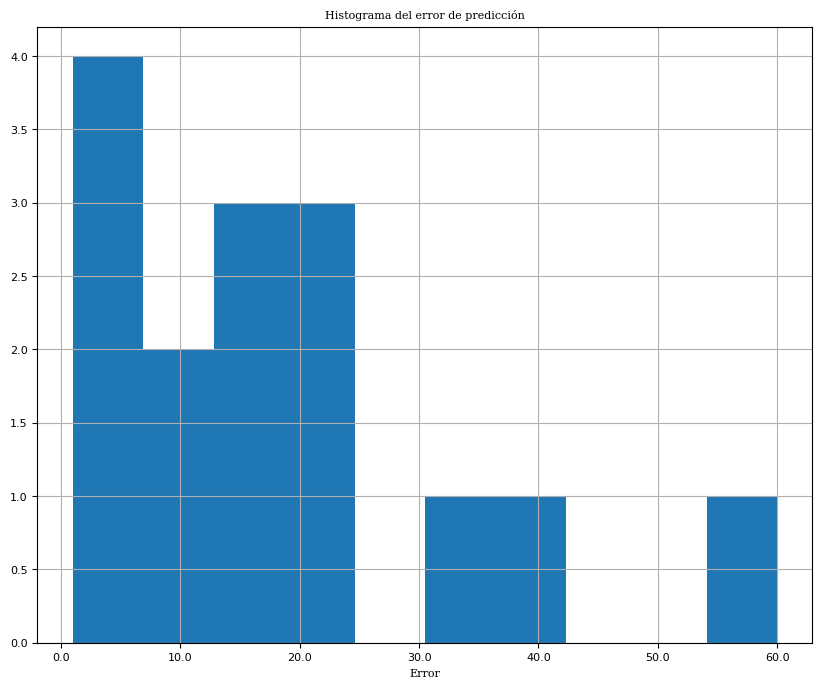

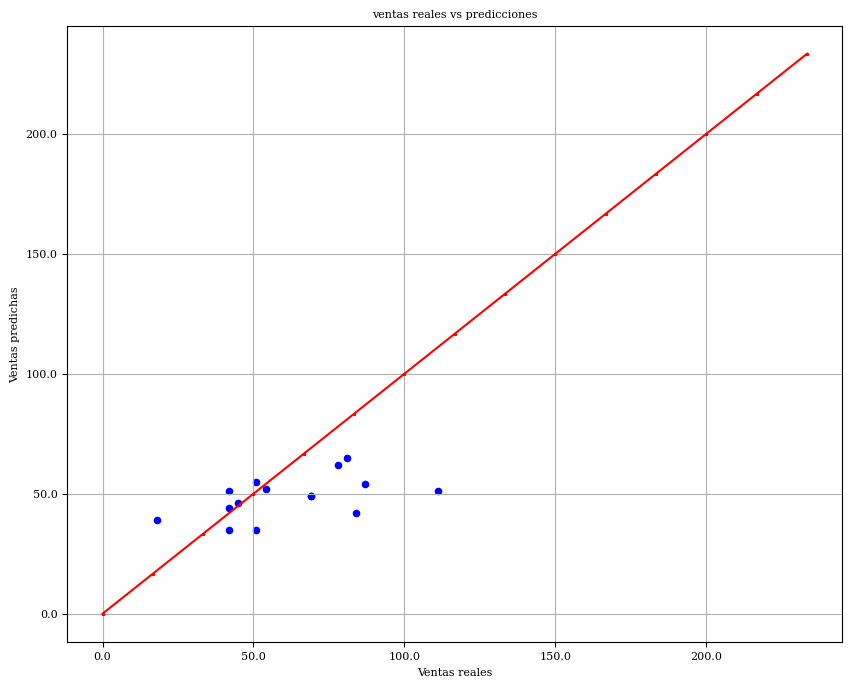

In [143]:
data = (X_train, Y_train, X_test, Y_test)

comparison = singleResultsAndPlots(best_model, data)

In [144]:
print("promedio de diferencia:", comparison["diff"].mean())
comparison

promedio de diferencia: 17.933333333333334


,venta real,venta predicha ML,fecha,diff,line,line2
0,18.00,39,2022-11-28,21.00,0.00,0.00
1,54.00,52,2022-12-05,2.00,16.67,16.67
2,42.00,35,2022-12-12,7.00,33.33,33.33
3,42.00,44,2022-12-19,2.00,50.00,50.00
4,84.00,42,2022-12-26,42.00,66.67,66.67
5,87.00,54,2023-01-02,33.00,83.33,83.33
6,51.00,35,2023-01-09,16.00,100.00,100.00
7,45.00,46,2023-01-16,1.00,116.67,116.67
8,42.00,51,2023-01-23,9.00,133.33,133.33
9,51.00,55,2023-01-30,4.00,150.00,150.00


* ***Anotaciones sobre algunas pruebas:***

* para familia: PANADERIA, item: 1043, día: Tuesday => shape(95, 15)
  - -M Squared E : 0.2000000000000019
  - -M Absolute E : 0.2000000000000019
  - Error acumulado : 3.0000000000000284
  - promedio de diferencia : 0.2

* para familia: PASTELERIA, item: 5403, día: Monday => shape(77, 15)
  - -M Squared E : 0.2741333588282374
  - -M Absolute E : 0.37000000476837164
  - Error acumulado : 4.44000005722046
  - promedio de diferencia : 0.3

* para familia: PANADERIA, item: 417, día: Friday => shape(95, 15)
  - -M Squared E : 0.6000000000000019
  - -M Absolute E : 0.600000000000001
  - Error acumulado : 9.000000000000014
  - promedio de diferencia : 0.6

## **4.2** ejecución de **predicciones para cada item por cada día**
* se chequea la efectividad de este método ( división por días, por productos, con el modelo predictivo mas efectivo para cada caso particular) almacenando los resultados de promedio de diferencia entre Y real e Y predicha

In [145]:
for family in (list(orderItemsPerDay.keys())):
  print(f"familia {family}:")
  for item in(list(orderItemsPerDay[family].keys())):
    print(f"item {item}: \n")
    for day in (list(orderItemsPerDay[family][item].keys())):
      print(f"día: {day} ; {orderItemsPerDay[family][item][day].shape}")
      itemSalesSuperviced = orderItemsPerDay[family][item][day]
      testrate = 0.15
      size = int((1-testrate)*len(itemSalesSuperviced))

      # Dividir en datos de entrenamiento y prueba
      Data_train = itemSalesSuperviced.iloc[:size, :]
      Data_test = itemSalesSuperviced.iloc[size:, :]
      testDates = Data_test["fecha_venta"].to_list()

      print(f"Data_train: {Data_train.shape}, Data_test: {Data_test.shape}")

      # Escalar los datos
      dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
      dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

      X_train = np.array(dfTrain_scaled[varcols])
      Y_train = np.array(dfTrain_scaled[label])

      X_test = np.array(dfTest_scaled[varcols])
      Y_test = np.array(dfTest_scaled[label])

      data = (X_train, Y_train, X_test, Y_test)
      results, best_model = basic_modelMetrics_compared_ts(data, models, simple_model_params)
      comparison = singleResultsAndPlots(best_model, data, plotAll=False, noPlot=True)
      print(f"promedio de diferencia para el item {item} en el día {day}:", comparison["diff"].mean(), "\n")
    print("----------------------------------\n")

familia BOLLERIA:
item 3960: 

día: Monday ; (95, 15)
Data_train: (80, 15), Data_test: (15, 15)
Mejor modelo basado en CV: AdaBoost con CV_Mean_AE: 0.17357926035365573
promedio de diferencia para el item 3960 en el día Monday: 66.4 

día: Tuesday ; (95, 15)
Data_train: (80, 15), Data_test: (15, 15)
Mejor modelo basado en CV: Ridge con CV_Mean_AE: 0.12330475569898677
promedio de diferencia para el item 3960 en el día Tuesday: 77.06666666666666 

día: Wednesday ; (94, 15)
Data_train: (79, 15), Data_test: (15, 15)
Mejor modelo basado en CV: RandomForest con CV_Mean_AE: 0.17281177248677246
promedio de diferencia para el item 3960 en el día Wednesday: 32.86666666666667 

día: Thursday ; (95, 15)
Data_train: (80, 15), Data_test: (15, 15)
Mejor modelo basado en CV: LinearRegression con CV_Mean_AE: 0.15758846106461755
promedio de diferencia para el item 3960 en el día Thursday: 31.6 

día: Friday ; (95, 15)
Data_train: (80, 15), Data_test: (15, 15)
Mejor modelo basado en CV: Ridge con CV_Mean_

## **4.3** misma estrategia predictiva, esta vez con diferentes observaciones (*t*-**n**)
* se repiten las predicciones, está vez con diferentes conjuntos de datos supervizados, para determinar si la capacidad predictiva mejora, empeora o es indiferente a los datos de obervaciones supervizadas que se presenten

      series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily , n_in_weekly , n_out )

* en la instancia **4.2** las observaciones constaban de *t*-**5** días



### **4.3.1** observaciones de *t*-**2** días y *t*-**0** semana

In [146]:
orderItemsPerDay = supervicedItemsPerDay_Dict(df, n_in_daily=2, n_in_weekly=0, printAll=False)

varcols = ['var1(t-2 day)_scld', 'var1(t-1 day)_scld',
       'tavg_w_scld', 'lluvia_scld', 'isfestivo_scld', "month", "year"]

for family in (list(orderItemsPerDay.keys())):
  print(f"familia {family}:")
  for item in(list(orderItemsPerDay[family].keys())):
    print(f"item {item}: \n")
    for day in (list(orderItemsPerDay[family][item].keys())):
      print(f"día: {day} ; {orderItemsPerDay[family][item][day].shape}")
      itemSalesSuperviced = orderItemsPerDay[family][item][day]
      testrate = 0.15
      size = int((1-testrate)*len(itemSalesSuperviced))

      # Dividir en datos de entrenamiento y prueba
      Data_train = itemSalesSuperviced.iloc[:size, :]
      Data_test = itemSalesSuperviced.iloc[size:, :]
      testDates = Data_test["fecha_venta"].to_list()

      print(f"Data_train: {Data_train.shape}, Data_test: {Data_test.shape}")

      # Escalar los datos
      dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
      dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

      X_train = np.array(dfTrain_scaled[varcols])
      Y_train = np.array(dfTrain_scaled[label])

      X_test = np.array(dfTest_scaled[varcols])
      Y_test = np.array(dfTest_scaled[label])

      print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}, X_test: {X_test.shape}, Y_test: {Y_test.shape}")
      data = (X_train, Y_train, X_test, Y_test)
      results, best_model = basic_modelMetrics_compared_ts(data, models, simple_model_params)
      comparison = singleResultsAndPlots(best_model, data, plotAll=False, noPlot=True)
      print(f"promedio de diferencia para el item {item} en el día {day}:", comparison["diff"].mean(), "\n")
    print("----------------------------------\n")

familia BOLLERIA:
item 3960: 

día: Monday ; (96, 12)
Data_train: (81, 12), Data_test: (15, 12)
X_train: (81, 7), Y_train: (81, 1), X_test: (15, 7), Y_test: (15, 1)
Mejor modelo basado en CV: KNeighbors con CV_Mean_AE: 0.1774942704354469
promedio de diferencia para el item 3960 en el día Monday: 63.93333333333333 

día: Tuesday ; (96, 12)
Data_train: (81, 12), Data_test: (15, 12)
X_train: (81, 7), Y_train: (81, 1), X_test: (15, 7), Y_test: (15, 1)
Mejor modelo basado en CV: AdaBoost con CV_Mean_AE: 0.1231144757635082
promedio de diferencia para el item 3960 en el día Tuesday: 65.6 

día: Wednesday ; (95, 12)
Data_train: (80, 12), Data_test: (15, 12)
X_train: (80, 7), Y_train: (80, 1), X_test: (15, 7), Y_test: (15, 1)
Mejor modelo basado en CV: SVR con CV_Mean_AE: 0.1756228831185182
promedio de diferencia para el item 3960 en el día Wednesday: 36.4 

día: Thursday ; (95, 12)
Data_train: (80, 12), Data_test: (15, 12)
X_train: (80, 7), Y_train: (80, 1), X_test: (15, 7), Y_test: (15, 1)
Me

### **4.3.2** observaciones de diferentes topologías *t*-**n** días y *t*-**n** semana
* considerando que lo resultados, para un conjunto **x**, son diferentes con diferentes muestras supervizadas, una todavía mejor performance podría darse si presentamos diferentes topologías de *t*-**n** días y *t*-**n** semanas y determinamos, para cada item, para cada día, que topología y que modelo predictivo es el mas acertado y utilizamos esa composición particular a futuro

In [147]:
def evaluate_configurations(df, tn_configurations, models, simple_model_params):
  results_summary = []
  for n_in_daily, n_in_weekly in tn_configurations:
    print(f"Evaluando configuración: n_in_daily: {n_in_daily}, n_in_weekly: {n_in_weekly}")
    print("__________________\n")
    orderItemsPerDay = supervicedItemsPerDay_Dict(df, n_in_daily=n_in_daily, n_in_weekly=n_in_weekly, printAll=False)

    # Generar varcols
    varcols = [f'var1(t-{i} day)_scld' for i in range(n_in_daily, 0, -1)] + \
              [f'var1(t-{i} week)_scld' for i in range(n_in_weekly, 0, -1)] + \
              ['tavg_w_scld', 'lluvia_scld', 'isfestivo_scld', 'month', 'year']

    for family in (list(orderItemsPerDay.keys())):
      # print(f"familia {family}:")
      for item in(list(orderItemsPerDay[family].keys())):
        # print(f"item {item}: \n")
        for day in (list(orderItemsPerDay[family][item].keys())):
          # print(f"día: {day} ; {orderItemsPerDay[family][item][day].shape}")
          itemSalesSuperviced = orderItemsPerDay[family][item][day]
          testrate = 0.15
          size = int((1-testrate)*len(itemSalesSuperviced))

          # Dividir en datos de entrenamiento y prueba
          Data_train = itemSalesSuperviced.iloc[:size, :]
          Data_test = itemSalesSuperviced.iloc[size:, :]
          testDates = Data_test["fecha_venta"].to_list()

          # Escalar los datos
          dfTrain_scaled, dfTrain_unscaler = tsscale(Data_train)
          dfTest_scaled, dfTest_unscaler = tsscale(Data_test)

          X_train = np.array(dfTrain_scaled[varcols])
          Y_train = np.array(dfTrain_scaled[label])

          X_test = np.array(dfTest_scaled[varcols])
          Y_test = np.array(dfTest_scaled[label])

          data = (X_train, Y_train, X_test, Y_test)
          results, best_model = basic_modelMetrics_compared_ts(data, models, simple_model_params)

          best_model.fit(X_train, Y_train)
          Y_pred = best_model.predict(X_test)

           # desescalado
          Y_predUnsc = dfTest_unscaler.inverse_transform(Y_pred.reshape(1,-1))[0]
          Y_testUnsc = dfTest_unscaler.inverse_transform(Y_test.reshape(1,-1))[0]

          # validación
          Y_predUnsc = Y_predUnsc.flatten().astype(int)
          Y_testUnsc = Y_testUnsc.flatten()

          # merge
          comparison = pd.DataFrame({"Y_real": Y_testUnsc, "Y_pred": Y_predUnsc})
          comparison["fecha"] = testDates
          comparison["diff"] = abs(comparison["Y_real"] - comparison["Y_pred"])
          mean_diff = comparison["diff"].mean()
          result_entry = {
              "family": family,
              "item": item,
              "day": day,
              "n_in_daily": n_in_daily,
              "n_in_weekly": n_in_weekly,
              "mean_diff": mean_diff,
              "model": best_model
          }
          results_summary.append(result_entry)
          print(f"promedio de diferencia para el item {item} en el día {day}:", mean_diff, "\n")

      print("----------------------------------\n")

  results_df = pd.DataFrame(results_summary)
  return results_df

# Configuraciones de n_in_daily y n_in_weekly a probar
tn_configurations = [(2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]

# Ejecutar el estudio
results_df = evaluate_configurations(df, tn_configurations, models, simple_model_params)

Evaluando configuración: n_in_daily: 2, n_in_weekly: 0
__________________

Mejor modelo basado en CV: AdaBoost con CV_Mean_AE: 0.17417958704250555
promedio de diferencia para el item 3960 en el día Monday: 68.46666666666667 

Mejor modelo basado en CV: AdaBoost con CV_Mean_AE: 0.12033076734043528
promedio de diferencia para el item 3960 en el día Tuesday: 68.86666666666666 

Mejor modelo basado en CV: SVR con CV_Mean_AE: 0.1756228831185182
promedio de diferencia para el item 3960 en el día Wednesday: 36.4 

Mejor modelo basado en CV: SVR con CV_Mean_AE: 0.16601085155884107
promedio de diferencia para el item 3960 en el día Thursday: 33.6 

Mejor modelo basado en CV: SVR con CV_Mean_AE: 0.186609162605176
promedio de diferencia para el item 3960 en el día Friday: 38.8 

Mejor modelo basado en CV: KNeighbors con CV_Mean_AE: 0.18225352112676058
promedio de diferencia para el item 3960 en el día Saturday: 57.8 

Mejor modelo basado en CV: SVR con CV_Mean_AE: 0.1459503589361418
promedio de d

In [148]:
results_df

,family,item,day,n_in_daily,n_in_weekly,mean_diff,model
0,BOLLERIA,3960,Monday,2,0,68.47,"(DecisionTreeRegressor(max_depth=3, random_sta..."
1,BOLLERIA,3960,Tuesday,2,0,68.87,"(DecisionTreeRegressor(max_depth=3, random_sta..."
2,BOLLERIA,3960,Wednesday,2,0,36.40,SVR()
3,BOLLERIA,3960,Thursday,2,0,33.60,SVR()
4,BOLLERIA,3960,Friday,2,0,38.80,SVR()
...,...,...,...,...,...,...,...
1150,PASTELERIA,6549,Wednesday,6,2,0.00,SVR()
1151,PASTELERIA,6549,Thursday,6,2,1.50,([DecisionTreeRegressor(criterion='friedman_ms...
1152,PASTELERIA,6549,Friday,6,2,4.15,SVR()
1153,PASTELERIA,6549,Saturday,6,2,13.08,SVR()


In [149]:
# Identificar las mejores y peores configuraciones para cada item y día
best_configurations = results_df.loc[results_df.groupby(['family', 'item', 'day'])['mean_diff'].idxmin()]
worst_configurations = results_df.loc[results_df.groupby(['family', 'item', 'day'])['mean_diff'].idxmax()]

print("Mejores configuraciones por item y día:")
best_configurations

Mejores configuraciones por item y día:


,family,item,day,n_in_daily,n_in_weekly,mean_diff,model
1068,BOLLERIA,3880,Friday,6,2,26.60,([DecisionTreeRegressor(criterion='friedman_ms...
119,BOLLERIA,3880,Monday,3,0,26.20,Ridge()
544,BOLLERIA,3880,Saturday,6,1,39.53,"(DecisionTreeRegressor(max_features=1.0, rando..."
440,BOLLERIA,3880,Sunday,6,0,51.67,"(DecisionTreeRegressor(max_features=1.0, rando..."
857,BOLLERIA,3880,Thursday,4,1,33.00,"(DecisionTreeRegressor(max_depth=3, random_sta..."
...,...,...,...,...,...,...,...
1153,PASTELERIA,6549,Saturday,6,2,13.08,SVR()
419,PASTELERIA,6549,Sunday,5,0,6.46,SVR()
1151,PASTELERIA,6549,Thursday,6,2,1.50,([DecisionTreeRegressor(criterion='friedman_ms...
99,PASTELERIA,6549,Tuesday,2,0,3.60,SVR()


In [150]:
localPath+notebookCsv_Path

'/content/drive/MyDrive/CodeSpace_DataScience/DataScience/DATATHON/datathon_csv/'

In [151]:
if False:
  best_configurations.to_csv(localPath+notebookCsv_Path+'best_configurations.csv', index=False)

In [152]:
print("\nPeores configuraciones por item y día:")
worst_configurations


Peores configuraciones por item y día:


,family,item,day,n_in_daily,n_in_weekly,mean_diff,model
858,BOLLERIA,3880,Friday,4,1,34.13,KNeighborsRegressor()
14,BOLLERIA,3880,Monday,2,0,30.13,"(DecisionTreeRegressor(max_features=1.0, rando..."
19,BOLLERIA,3880,Saturday,2,0,46.53,"(DecisionTreeRegressor(max_features=1.0, rando..."
20,BOLLERIA,3880,Sunday,2,0,67.00,"(DecisionTreeRegressor(max_depth=3, random_sta..."
17,BOLLERIA,3880,Thursday,2,0,45.80,Ridge()
...,...,...,...,...,...,...,...
103,PASTELERIA,6549,Saturday,2,0,13.29,SVR()
104,PASTELERIA,6549,Sunday,2,0,6.64,SVR()
626,PASTELERIA,6549,Thursday,6,1,3.50,ExtraTreeRegressor(random_state=42)
99,PASTELERIA,6549,Tuesday,2,0,3.60,SVR()


# **5.0 MLFlow**. Predicciónes para los ultimos valores de la serie

* Esta etapa, que conluirá con el Datathon en lo que a predicción de ventas se refiere, continuará en el notebook <*mlflow_predictions.ipynb*> para ser ejecutado en local y no, como hasta ahora, en googleColab. La razón de esto es disponer de las capacidades de conexión remota a través de puertos que nos ofrecen editores de texto como Visual Studio Code.
* La conclusión de este estudio es que la mayor performance para predecir las ventas a futuro a partir del material dispuesto ( la base de datos ofrecida y los modelos de predicción regresiva de la librería *sklearn* ) se da cuando separamos la base de datos en items de productos individuales, en días de la semana para cada item, y determinamos para cada **|** *item* **x** *día* **|** la mejor opción en cuanto a observaciones *t*-**n** y el mejor modelo predictivo de regresión para dicho conjunto, entendiendo por mejor opción aquel sistema que ofrece el menor promedio de diferencia entre el valor real y predicho del (*t* ) objetivo.
* *best_configurations.csv* : contiene dicha información:
      family	  item	day	    n_in_daily	n_in_weekly	mean_diff	model

      BOLLERIA	3880	Friday	  6	          2	        26.666667	GradientBoostingRegressor()

y será el punto de partida, para los estudios siguientes, para la generación de de predicciones a futuro y su final presentación en PowerBI

In [153]:
# Para cargar el DataFrame desde el archivo CSV
best_configurations = pd.read_csv(localPath+notebookCsv_Path+'best_configurations.csv')
best_configurations

,family,item,day,n_in_daily,n_in_weekly,mean_diff,model
0,BOLLERIA,3880,Friday,6,2,26.67,GradientBoostingRegressor()
1,BOLLERIA,3880,Monday,3,0,26.20,Ridge()
2,BOLLERIA,3880,Saturday,6,1,39.53,RandomForestRegressor(random_state=42)
3,BOLLERIA,3880,Sunday,6,1,51.47,AdaBoostRegressor(n_estimators=100)
4,BOLLERIA,3880,Thursday,3,1,40.67,Ridge()
...,...,...,...,...,...,...,...
100,PASTELERIA,6549,Saturday,6,2,13.08,SVR()
101,PASTELERIA,6549,Sunday,5,0,6.46,SVR()
102,PASTELERIA,6549,Thursday,6,2,1.50,RandomForestRegressor(random_state=42)
103,PASTELERIA,6549,Tuesday,2,0,3.60,SVR()


* Durante este estudio se utilizaron procesos de escalado y desescalado particulares para cada caso de estudio en concreto (cada item, por cada día). Durante la etapa siguiente se utilizará un una única base de datos con su escalado**/**desescalado para facilitar los procesos de computo

In [154]:
df

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wspd_w,pres_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear,es_festivo,lluvia,quintiles_tavg_w
0,BOLLERIA,3960,2021-05-18,NaN,2.32,216.00,500.69,1,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
1,PANADERIA,1043,2021-05-18,NaN,2.60,195.00,506.22,2,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
2,PANADERIA,968,2021-05-18,NaN,2.16,237.00,512.63,1,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
3,PANADERIA,1084,2021-05-18,NaN,0.87,345.00,298.43,4,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
4,BOLLERIA,5803,2021-05-18,NaN,2.73,72.00,196.34,5,19.80,18.00,...,11.80,1019.80,20,5,1,18,138,0,0,Temperatura normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317,PASTELERIA,5403,2021-10-09,NaN,36.82,74.55,2744.78,2,20.90,18.10,...,11.20,1018.90,40,10,5,9,282,0,0,Temperatura normal
10318,PANADERIA,1084,2021-10-09,NaN,0.87,327.00,282.86,4,20.90,18.10,...,11.20,1018.90,40,10,5,9,282,0,0,Temperatura normal
10319,PASTELERIA,6549,2021-10-09,NaN,29.86,30.00,895.92,5,20.90,18.10,...,11.20,1018.90,40,10,5,9,282,0,0,Temperatura normal
10320,BOLLERIA,3880,2021-10-09,NaN,3.00,108.00,324.00,3,20.90,18.10,...,11.20,1018.90,40,10,5,9,282,0,0,Temperatura normal
